# 2 Modele

In [1]:
!pip install scikit-learn xgboost tensorflow shap pandas matplotlib seaborn tqdm numpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# preprocesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Modele klasyfikacji
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Ewaluacja modeli
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

# XAI
import shap

# Inne
import warnings
warnings.filterwarnings('ignore') # Ignorowanie ostrzeżeń dla czystości outputu

C:\Folder_python\envs\mgr\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2.0 Wczytanie danych

In [2]:
print("Wczytywanie zbiorów danych...")

try:
    # index_col=0 przywraca oryginalne indeksy pasażerów
    X_train_final = pd.read_csv('../Data/NPS_final/X_train_final.csv', index_col=0)
    X_val_final   = pd.read_csv('../Data/NPS_final/X_val_final.csv', index_col=0)
    X_test_final  = pd.read_csv('../Data/NPS_final/X_test_final.csv', index_col=0)
    
    # y wczytujemy jako Series (squeeze=True lub wybór kolumny)
    y_train = pd.read_csv('../Data/NPS_final/y_train.csv', index_col=0).squeeze()
    y_val   = pd.read_csv('../Data/NPS_final/y_val.csv', index_col=0).squeeze()
    y_test  = pd.read_csv('../Data/NPS_final/y_test.csv', index_col=0).squeeze()
    
    print("Dane wczytane pomyślnie.")
    print(f"Kształty zbiorów: Train {X_train_final.shape}, Val {X_val_final.shape}, Test {X_test_final.shape}")

except FileNotFoundError as e:
    print(f"Błąd: Nie znaleziono plików.\n{e}")

Wczytywanie zbiorów danych...
Dane wczytane pomyślnie.
Kształty X: Train (62094, 56), Val (13306, 56), Test (13307, 56)


In [3]:
'''
# Dodanie wyników analizy sentymentu (odkomentować, aby uwzględnić sentyment w y)
try:
    print("\n--- Rozpoczynam procedurę korekty NPS na podstawie sentymentu ---")
    print("1. Szukam pliku z analizą sentymentu...")
    sentiment_results = pd.read_csv('../Data/nps_sentiment_results.csv', index_col=0)
    
    # Lista zbiorów do przetworzenia w pętli (żeby nie kopiować kodu 3 razy)
    datasets_to_correct = [
        ('y_train', y_train),
        ('y_val',   y_val),
        ('y_test',  y_test)
    ]

    for name, y_current in datasets_to_correct:
        print(f"\nAnaliza zbioru: {name}")
        print("Rozkład NPS przed korektą sentymentem:")
        print(y_current.value_counts())

        # łączenie w jedną tabelę tymczasową, żeby dopasować sentyment po indeksie
        # Używamy how='left', żeby zachować tylko pasażerów z danego zbioru (train/val/test)
        temp_df = y_current.to_frame(name='NPS').join(sentiment_results, how='left')
        
        # Wypełniamy braki dla porządku (Ci, co nie byli analizowani)
        temp_df['Sentiment_Flag'] = temp_df['Sentiment_Flag'].fillna('Not_Analyzed')

        # Nadpisywanie NPS
        # Logika: Jeśli sentyment jest 'Negative', zmieniamy NPS na 1 (Detraktor)
        # Wykorzystujemy indeksy pasażerów
        
        mask_negative = temp_df['Sentiment_Flag'] == 'Negative'
        count_to_change = mask_negative.sum()
        
        print(f"Znaleziono {count_to_change} pasywnych klientów z negatywnym komentarzem.")
        
        if count_to_change > 0:
            print("Zmieniam ich status na Detraktorów (NPS = 1)...")
            # Nadpisujemy wartości w oryginalnym Series y (np. y_train)
            y_current.loc[mask_negative] = 1
        else:
            print("Brak zmian w tym zbiorze.")

        # ---------------------------------------------------------
        print(f"Rozkład NPS w {name} po korekcie:")
        print(y_current.value_counts())

    print("\nSukces! Zaktualizowano kolumny NPS we wszystkich zbiorach (Train/Val/Test).")

except FileNotFoundError:
    print("BŁĄD: Nie znaleziono pliku '../Data/nps_sentiment_results.csv'.")
    print("Uruchom najpierw skrypt 'NPS-Sentyment'.")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")
'''

'\n# Dodanie wyników analizy sentymentu (odkomentować, aby uwzględnić sentyment w y)\ntry:\n    print("\n--- Rozpoczynam procedurę korekty NPS na podstawie sentymentu ---")\n    print("1. Szukam pliku z analizą sentymentu...")\n    sentiment_results = pd.read_csv(\'../Data/nps_sentiment_results.csv\', index_col=0)\n\n    # Lista zbiorów do przetworzenia w pętli (żeby nie kopiować kodu 3 razy)\n    datasets_to_correct = [\n        (\'y_train\', y_train),\n        (\'y_val\',   y_val),\n        (\'y_test\',  y_test)\n    ]\n\n    for name, y_current in datasets_to_correct:\n        print(f"\nAnaliza zbioru: {name}")\n        print("Rozkład NPS przed korektą sentymentem:")\n        print(y_current.value_counts())\n\n        # łączenie w jedną tabelę tymczasową, żeby dopasować sentyment po indeksie\n        # Używamy how=\'left\', żeby zachować tylko pasażerów z danego zbioru (train/val/test)\n        temp_df = y_current.to_frame(name=\'NPS\').join(sentiment_results, how=\'left\')\n\n     

## 2.1 Modele drzewiaste

### 2.1.1 Drzewa

In [4]:
# Trzy warianty modeli drzew
# W każdym używam balanced, cosprawia, że biblioteka automatycznie doważa rzadszą klasę.
# To też implikuje nam niższą precyzję, model częściej oznaczy kogoś niezadowolonego aby nie przeoczyć nikogo, dlatego jest duży recall
# Bez zbalansowania klas cechy, które są kluczowe dla "niezadowolonych" zostaną stłumione przez cechy typowe dla "zadowolonych" (większości)

models_trees = {
    "Model 1: Swobodny": DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42
        # Brak ograniczeń głębokości
    ),
    
    "Model 2: Płytki": DecisionTreeClassifier(
        class_weight='balanced', 
        max_depth=4,            # krótkie drzewo
        min_samples_leaf=50,    # Duże liście
        random_state=42
    ),
    
    "Model 3: Środkowy": DecisionTreeClassifier(
        class_weight='balanced', 
        max_depth=8,            # Większa głębokość drzewa
        min_samples_leaf=20,    # Mniejsze liście
        min_samples_split=50,
        random_state=42
    )
}

In [5]:
# Zmienne do śledzenia lidera
best_model_name = ""
best_model_obj = None
best_val_auc = 0

print(f"{'-'*20} ETAP 1: TRENING I WALIDACJA (Szukanie modelu) {'-'*20}")


for name, model in models_trees.items():
    print(f"\n--- {name} ---")
    
    model.fit(X_train_final, y_train)
    
    # Predykcja na treningu i walidacyjnym
    y_pred_train = model.predict(X_train_final)
    y_pred_val = model.predict(X_val_final)
    y_prob_val = model.predict_proba(X_val_final)[:, 1]
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego modelu na podstawie AUC na walidacji
    if auc_val > best_val_auc:
        best_val_auc = auc_val
        best_model_obj = model
        best_model_name = name


print(f"\n\n{'-'*20} Sprawdzam najlepszy model na zbiorze testowym {'-'*20}")
print(f"najwyższy AUC na zbiorze walidacyjnym osiągnął: {best_model_name}")

y_pred_final = best_model_obj.predict(X_test_final)
y_prob_final = best_model_obj.predict_proba(X_test_final)[:, 1]

final_acc = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_prob_final)
final_report = classification_report(y_test, y_pred_final)

print(f"\n- WYNIKI KOŃCOWE -")
print(f"Final Accuracy: {final_acc:.2%}")
print(f"Final ROC-AUC:  {final_auc:.4f}")
print("\nPełny raport klasyfikacji:")
print(final_report)

-------------------- ETAP 1: TRENING I WALIDACJA (Szukanie modelu) --------------------

--- Model 1: Swobodny ---
Accuracy Train: 99.42%
Accuracy Val:   87.31%
ROC-AUC Val:    0.7383

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 58.97%
Precision:        58.33%

--- Model 2: Płytki ---
Accuracy Train: 79.13%
Accuracy Val:   79.09%
ROC-AUC Val:    0.8859

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 87.14%
Precision:        41.24%

--- Model 3: Środkowy ---
Accuracy Train: 87.47%
Accuracy Val:   87.56%
ROC-AUC Val:    0.9254

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 85.17%
Precision:        56.08%


-------------------- Sprawdzam najlepszy model na zbiorze testowym --------------------
najwyższy AUC na zbiorze walidacyjnym osiągnął: Model 3: Środkowy

- WYNIKI KOŃCOWE (Do raportu) -
Final Accuracy: 86.74%
Final ROC-AUC:  0.9179

Pełny raport klasyfikacji:
              precision 

### 2.1.2 Lasy Losowe

In [6]:
# Definiujemy 3 warianty Lasów Losowych
models_rf = {
    "RF Model 1: Swobodny": RandomForestClassifier(
        n_estimators=200,       # 200 drzew
        class_weight='balanced', 
        max_depth=None,         # Drzewa mogą rosnąć jak chcą
        n_jobs=-1,              
        random_state=42
    ),
    
    "RF Model 2: Konserwatywny": RandomForestClassifier(
        n_estimators=100,       # Mniej drzew wystarczy przy prostym modelu
        class_weight='balanced', 
        max_depth=6,            # Bardzo płytkie drzewa (tylko główne reguły)
        min_samples_leaf=50,    # Duże grupy w liściach
        n_jobs=-1,
        random_state=42
    ),
    
    "RF Model 3: Środkowy": RandomForestClassifier(
        n_estimators=300,       # Więcej drzew 
        class_weight='balanced_subsample', # Wersja precyzyjniejsza wag dla lasów
        max_depth=12,           # Większa głębokość
        min_samples_leaf=10,    # Mniejsze liście
        max_features='sqrt',    
        n_jobs=-1,
        random_state=42
    )
}

In [7]:
# Zmienne do śledzenia lidera w kategorii Lasów
best_rf_name = ""
best_rf_obj = None
best_rf_val_auc = 0

print(f"{'-'*20} WALIDACJA LASÓW LOSOWYCH (Szukanie modelu) {'-'*20}")


for name, model in models_rf.items():
    print(f"\n--- {name} ---")
    
    model.fit(X_train_final, y_train)
    
    # Predykcja na treningu i walidacyjnym
    y_pred_train = model.predict(X_train_final)
    y_pred_val = model.predict(X_val_final)
    y_prob_val = model.predict_proba(X_val_final)[:, 1]

    #train
    acc_train = accuracy_score(y_train, y_pred_train)
    #val
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)

    # metryki
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego modelu na podstawie AUC na walidacji
    if auc_val > best_rf_val_auc:
        best_rf_val_auc = auc_val
        best_rf_obj = model
        best_rf_name = name


print(f"\n\n{'-'*20} Sprawdzam najlepszy model na zbiorze testowym {'-'*20}")
print(f"najwyższy AUC na zbiorze walidacyjnym osiągnął: {best_rf_name}")

y_pred_final_rf = best_rf_obj.predict(X_test_final)
y_prob_final_rf = best_rf_obj.predict_proba(X_test_final)[:, 1]

final_acc_rf = accuracy_score(y_test, y_pred_final_rf)
final_auc_rf = roc_auc_score(y_test, y_prob_final_rf)
final_report_rf = classification_report(y_test, y_pred_final_rf)

print(f"\n- WYNIKI KOŃCOWE -")
print(f"Final Accuracy: {final_acc_rf:.2%}")
print(f"Final ROC-AUC:  {final_auc_rf:.4f}")
print("\nPełny raport klasyfikacji:")
print(final_report_rf)


-------------------- WALIDACJA LASÓW LOSOWYCH (Szukanie modelu) --------------------

--- RF Model 1: Swobodny ---
Accuracy Train: 99.57%
Accuracy Val:   91.67%
ROC-AUC Val:    0.9329

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 60.64%
Precision:        79.88%

--- RF Model 2: Konserwatywny ---
Accuracy Train: 86.49%
Accuracy Val:   86.37%
ROC-AUC Val:    0.9285

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 82.86%
Precision:        53.45%

--- RF Model 3: Środkowy ---
Accuracy Train: 89.05%
Accuracy Val:   88.38%
ROC-AUC Val:    0.9407

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 84.63%
Precision:        58.20%


-------------------- Sprawdzam najlepszy model na zbiorze testowym --------------------
najwyższy AUC na zbiorze walidacyjnym osiągnął: RF Model 3: Środkowy

- WYNIKI KOŃCOWE (Do raportu) -
Final Accuracy: 87.97%
Final ROC-AUC:  0.9361

Pełny raport klasyfikacji:
        

### 2.1.3 XGBOOST

In [8]:
# Dynamiczne obliczenie wagi (scale_pos_weight)
# Liczymy to tylko na zbiorze treningowym, żeby nie było wycieku danych
num_neg = (y_train == 0).sum()  # Zadowoleni
num_pos = (y_train == 1).sum() 

scale_weight = num_neg / num_pos
print(f"Obliczony scale_pos_weight: {scale_weight:.4f}")
print(f"(Na każdego niezadowolonego przypada około {scale_weight:.2f} zadowolonych)\n")

models_xgb = {
    "XGB 1: Swobodny": XGBClassifier(
        n_estimators=500,       # Dużo drzew
        max_depth=12,           # Bardzo głębokie drzewa (ryzyko overfittingu)
        learning_rate=0.3,      # Szybka nauka
        scale_pos_weight=scale_weight,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ),
    
    "XGB 2: Płytki": XGBClassifier(
        n_estimators=100,
        max_depth=3,            # Bardzo płytkie
        learning_rate=0.05,     # Powolna, ostrożna nauka
        scale_pos_weight=scale_weight,
        reg_lambda=10,          # Silna regularyzacja L2 (zapobiega przeuczeniu)
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ),
    
    "XGB 3: Środkowy": XGBClassifier(
        n_estimators=300,
        max_depth=6,            # Standardowa głębokość
        learning_rate=0.1,      # Złoty środek
        scale_pos_weight=scale_weight,
        subsample=0.8,          # Używaj 80% danych dla każdego drzewa
        colsample_bytree=0.8,   # Używaj 80% cech dla każdego drzewa
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )
}

Obliczony scale_pos_weight: 5.5555
(Na każdego niezadowolonego przypada około 5.56 zadowolonych)



In [9]:
# Zmienne do śledzenia lidera w kategorii XGBoost
best_xgb_name = ""
best_xgb_obj = None
best_xgb_val_auc = 0

print(f"{'-'*20} WALIDACJA XGBOOST (Szukanie modelu) {'-'*20}")


for name, model in models_xgb.items():
    print(f"\n--- {name} ---")
    
    model.fit(X_train_final, y_train)
    
    # Predykcja na treningu i walidacyjnym
    y_pred_train = model.predict(X_train_final)
    y_pred_val = model.predict(X_val_final)
    y_prob_val = model.predict_proba(X_val_final)[:, 1]
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego modelu na podstawie AUC na walidacji
    if auc_val > best_xgb_val_auc:
        best_xgb_val_auc = auc_val
        best_xgb_obj = model
        best_xgb_name = name


print(f"\n\n{'-'*20} Sprawdzam najlepszy model na zbiorze testowym {'-'*20}")
print(f"najwyższy AUC na zbiorze walidacyjnym osiągnął: {best_xgb_name}")

y_pred_final_xgb = best_xgb_obj.predict(X_test_final)
y_prob_final_xgb = best_xgb_obj.predict_proba(X_test_final)[:, 1]

final_acc_xgb = accuracy_score(y_test, y_pred_final_xgb)
final_auc_xgb = roc_auc_score(y_test, y_prob_final_xgb)
final_report_xgb = classification_report(y_test, y_pred_final_xgb)

print(f"\n- WYNIKI KOŃCOWE -")
print(f"Final Accuracy: {final_acc_xgb:.2%}")
print(f"Final ROC-AUC:  {final_auc_xgb:.4f}")
print("\nPełny raport klasyfikacji:")
print(final_report_xgb)

-------------------- WALIDACJA XGBOOST (Szukanie modelu) --------------------

--- XGB 1: Swobodny ---
Accuracy Train: 99.49%
Accuracy Val:   90.84%
ROC-AUC Val:    0.8862

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 69.70%
Precision:        70.08%

--- XGB 2: Płytki ---
Accuracy Train: 88.25%
Accuracy Val:   88.58%
ROC-AUC Val:    0.9397

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 84.78%
Precision:        58.70%

--- XGB 3: Środkowy ---
Accuracy Train: 92.41%
Accuracy Val:   90.05%
ROC-AUC Val:    0.9411

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 83.50%
Precision:        63.15%


-------------------- Sprawdzam najlepszy model na zbiorze testowym --------------------
najwyższy AUC na zbiorze walidacyjnym osiągnął: XGB 3: Środkowy

- WYNIKI KOŃCOWE (Do raportu) -
Final Accuracy: 89.62%
Final ROC-AUC:  0.9334

Pełny raport klasyfikacji:
              precision    recall  f1-scor

## 2.2 Sieci neuronowe

In [10]:
# Aby wynik za każdym razem był ten sam deklaruję losowość
def reset_seeds(seed_value=42):
    # Losowość systemowa/Pythona
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    
    # Losowość Numpy (operacje na macierzach)
    np.random.seed(seed_value)
    
    # Losowość TensorFlow (wagi sieci)
    tf.random.set_seed(seed_value)

# Wywołaj to RAZ na początku skryptu
reset_seeds()

In [11]:
# Skalowanie, sproawdzam do wspólnego mianownika
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final) # Skaler uczony jest na treningu
X_val_scaled = scaler.transform(X_val_final)         # Aplikowany na walidacji
X_test_scaled = scaler.transform(X_test_final)       # i na teście

# Dla sieci wagi klas musimy zdefiniować słownikiem
# 0 = Zadowoleni, 1 = Niezadowoleni
# wzór na wagę: waga = n_samples / (n_classes * n_samples_j)
total = len(y_train)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

weight_for_0 = (1 / neg) * (total / 2.0) # 2 bo mamy 2 klasy
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Wagi dla sieci: Klasa 0: {weight_for_0:.2f}, Klasa 1: {weight_for_1:.2f}")
print(f"Liczba cech wejściowych: {X_train_scaled.shape[1]}")

Wagi dla sieci: Klasa 0: 0.59, Klasa 1: 3.28
Liczba cech wejściowych: 56


In [12]:
def build_nn_model(model_type, input_dim):
    model = Sequential()
    
    if model_type == "Głęboka":
        # Dużo warstw, dużo neuronów, brak Dropoutu
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid')) # Wyjście binarne
        
    elif model_type == "Płytka":
        # Mała sieć z dużą regularyzacją (Dropout)
        model.add(Dense(32, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.5)) # Wyłącza 50% neuronów losowo (ogrnaicza overfitting)
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        
    elif model_type == "Środkowa":
        # Złoty środek
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['AUC']) # Chcę śledzić AUC w trakcie nauki
    return model

model_names = ["Głęboka", "Płytka", "Środkowa"]

In [13]:
# Zmienne do śledzenia lidera w kategorii Sieci
best_nn_name = ""
best_nn_model = None
best_nn_val_auc = 0

print(f"{'-'*20} WALIDACJA SIECI NEURONOWYCH (Szukanie modelu) {'-'*20}")

for name in model_names:
    reset_seeds() # Reset losowości dla powtarzalności
    print(f"\n--- {name} ---")
    
    model = build_nn_model(name, X_train_scaled.shape[1])
    
    # Early Stopping
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Trenowanie
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weights, 
        callbacks=[callback],
        verbose=0
    )
    
    print(f"Zatrzymano po {len(history.epoch)} epokach.")
    
    # Predykcja na treningu i walidacyjnym
    # Train
    y_pred_prob_train = model.predict(X_train_scaled, verbose=0).flatten()
    y_pred_train = (y_pred_prob_train > 0.5).astype(int)
    
    # Val
    y_pred_prob_val = model.predict(X_val_scaled, verbose=0).flatten()
    y_pred_val = (y_pred_prob_val > 0.5).astype(int)
    
    # Metryki
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_pred_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")
    
    # Wybór najlepszej sieci
    if auc_val > best_nn_val_auc:
        best_nn_val_auc = auc_val
        best_nn_model = model
        best_nn_name = name


print(f"\n\n{'-'*20} Sprawdzam najlepszy model na zbiorze testowym {'-'*20}")
print(f"najwyższy AUC na zbiorze walidacyjnym osiągnął: {best_nn_name}")

y_pred_prob_final_nn = best_nn_model.predict(X_test_scaled, verbose=0).flatten()
y_pred_final_nn = (y_pred_prob_final_nn > 0.5).astype(int)

final_acc_nn = accuracy_score(y_test, y_pred_final_nn)
final_auc_nn = roc_auc_score(y_test, y_pred_prob_final_nn)
final_report_nn = classification_report(y_test, y_pred_final_nn)

print(f"\n- WYNIKI KOŃCOWE -")
print(f"Final Accuracy: {final_acc_nn:.2%}")
print(f"Final ROC-AUC:  {final_auc_nn:.4f}")
print("\nPełny raport klasyfikacji:")
print(final_report_nn)

-------------------- WALIDACJA SIECI NEURONOWYCH (Szukanie modelu) --------------------

--- Głęboka ---
Zatrzymano po 11 epokach.
Accuracy Train: 87.98%
Accuracy Val:   87.15%
ROC-AUC Val:    0.9367

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 87.09%
Precision:        54.98%

--- Płytka ---
Zatrzymano po 18 epokach.
Accuracy Train: 86.52%
Accuracy Val:   86.32%
ROC-AUC Val:    0.9387

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 87.14%
Precision:        53.16%

--- Środkowa ---
Zatrzymano po 12 epokach.
Accuracy Train: 87.93%
Accuracy Val:   87.87%
ROC-AUC Val:    0.9405

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 86.65%
Precision:        56.71%


-------------------- Sprawdzam najlepszy model na zbiorze testowym --------------------
najwyższy AUC na zbiorze walidacyjnym osiągnął: Środkowa

- WYNIKI KOŃCOWE (Do raportu) -
Final Accuracy: 87.71%
Final ROC-AUC:  0.9365

Pełny rapo

## 2.3 Gain

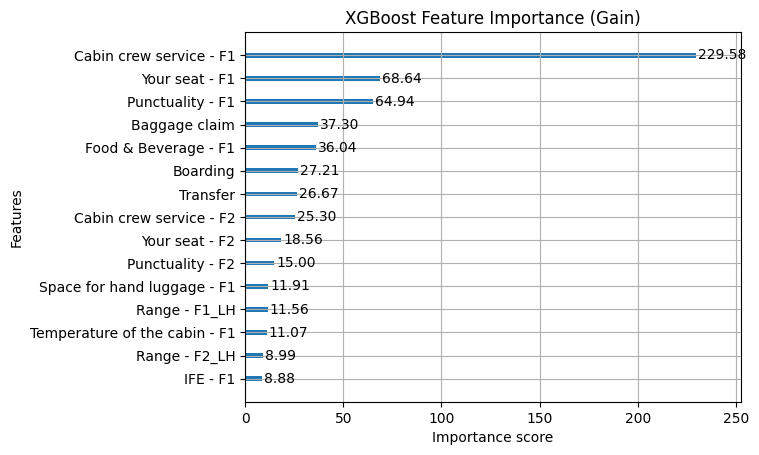

In [14]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

ax = plot_importance(best_xgb_obj, max_num_features=15, importance_type='gain', title='XGBoost Feature Importance (Gain)')

for text in ax.texts:
    try:
        value = float(text.get_text())
        text.set_text(f'{value:.2f}')
    except ValueError:
        pass

plt.show()

## 2.4 Ważność Permutacyjna

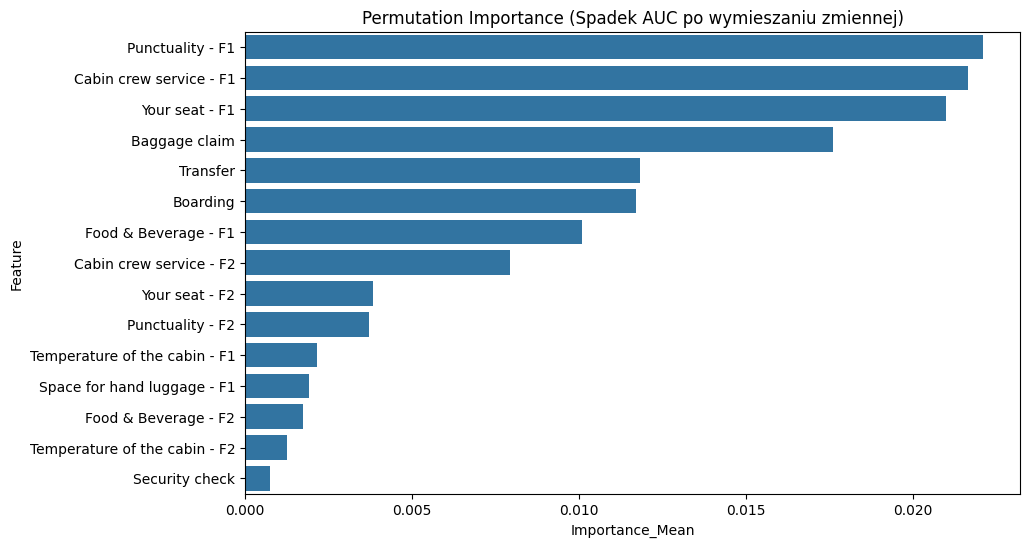

In [15]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_xgb_obj, X_test_final, y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1,
    scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'Feature': X_test_final.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance_Mean', y='Feature', data=perm_df.head(15))
plt.title("Permutation Importance (Spadek AUC po wymieszaniu zmiennej)")
plt.show()

## 2.5 Analiza SHAP

In [16]:
# Wyświetlenie listy kolumn jakie mam końcowo w zbiorze
cols = X_test_final.columns.tolist()

print(f"Pełna lista zmiennych objaśniających (Łącznie: {len(cols)}) ===")
print("-" * 50)

for i, col in enumerate(cols):
    print(f"{i+1}. {col}")

=== LISTA ZMIENNYCH W X_test_final (Łącznie: 56) ===
--------------------------------------------------
1. M&M Flag
2. Transfer Flag
3. IFE Flag - F1
4. IFE Flag - F2
5. Group Flag
6. Baggage Flag
7. Accessories - F1 Flag
8. Accessories - F2 Flag
9. BL Flag
10. Boarding
11. Security check
12. Transfer
13. Baggage claim
14. Business Lounge
15. Punctuality - F1
16. Cabin crew service - F1
17. Food & Beverage - F1
18. IFE - F1
19. Your seat - F1
20. Space for hand luggage - F1
21. Temperature of the cabin - F1
22. Accessories - F1
23. Punctuality - F2
24. Cabin crew service - F2
25. Food & Beverage - F2
26. IFE - F2
27. Your seat - F2
28. Space for hand luggage - F2
29. Temperature of the cabin - F2
30. Accessories - F2
31. Range - F1_DOM
32. Range - F1_LH
33. Range - F1_SH
34. Range - F2_DOM
35. Range - F2_LH
36. Range - F2_SH
37. Cabin Class - F1_C
38. Cabin Class - F1_P
39. Cabin Class - F1_Y
40. Cabin Class - F2_C
41. Cabin Class - F2_P
42. Cabin Class - F2_Y
43. Purpose of trip_Other

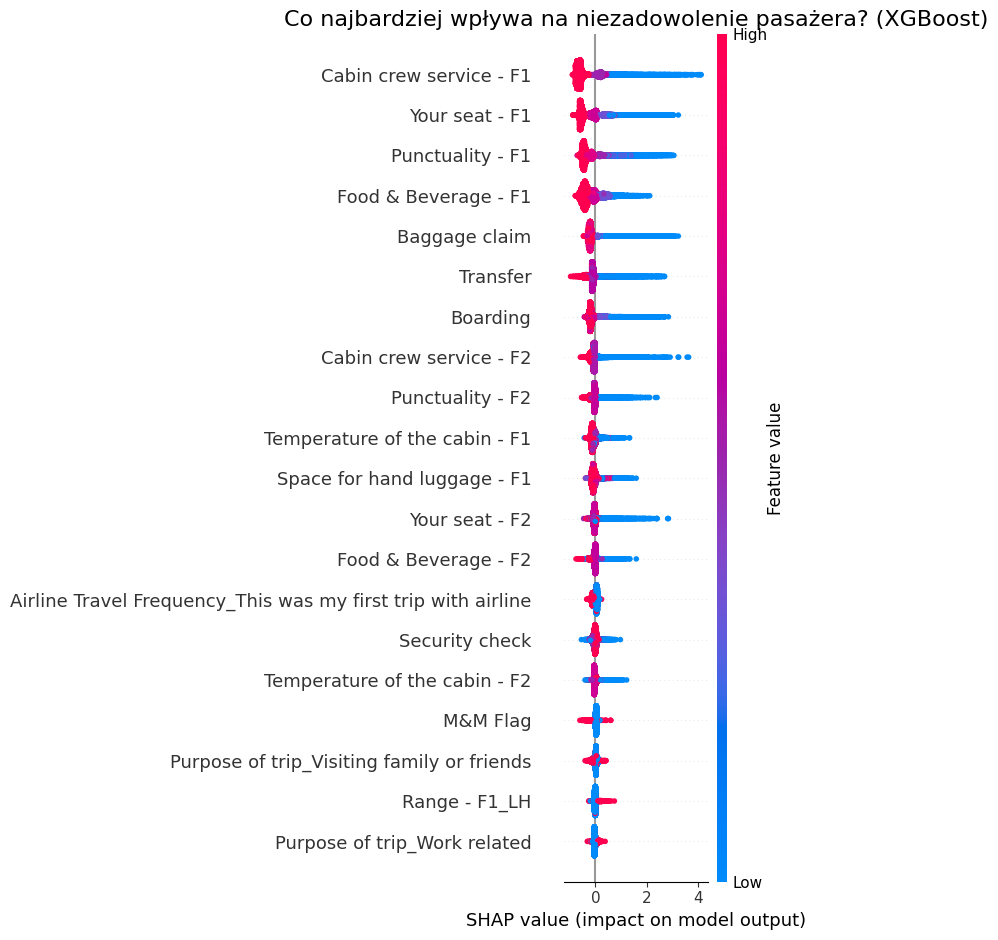

In [17]:
### Wykres SHAP globalny

# Przygotowanie Explainera dla XGBoosta
# TreeExplainer jest dedykowany dla drzew i jest bardzo szybki to zaleta nie korzystania z sieci neuronowej
explainer = shap.TreeExplainer(best_xgb_obj)

# Obliczenie wartości SHAP dla zbioru testowego
# (Liczymy to na danych, których model nie widział podczas treningu)
shap_values = explainer.shap_values(X_test_final)

# Rysowanie wykresu
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_final, show=False)
plt.title("Co najbardziej wpływa na niezadowolenie pasażera? (XGBoost)", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# Średni wpływ, maksymalny i proporcja dla wszystkich pasażerów

# 1. Obliczenia (Twoja logika)
mean_shap = np.abs(shap_values).mean(axis=0)
max_shap = np.abs(shap_values).max(axis=0)

df_comparison = pd.DataFrame({
    'Feature': X_test_final.columns,
    'Mean_Impact (Global)': mean_shap,
    'Max_Impact (Local)': max_shap
})

# Obliczamy Niche Ratio
df_comparison['Niche_Ratio'] = df_comparison['Mean_Impact (Global)'] / df_comparison['Max_Impact (Local)']

# Sortujemy
df_comparison = df_comparison.sort_values(by='Mean_Impact (Global)', ascending=False).reset_index(drop=True)

# formatowanie warunkowe
styled_table = df_comparison.style.format({
    'Mean_Impact (Global)': '{:.4f}',
    'Max_Impact (Local)': '{:.4f}',
    'Niche_Ratio': '{:.4f}'
}).background_gradient(
    subset=['Mean_Impact (Global)'], cmap='Reds'  # Czerwony dla siły globalnej
).background_gradient(
    subset=['Max_Impact (Local)'], cmap='Blues'   # Niebieski dla siły lokalnej
).background_gradient(
    subset=['Niche_Ratio'], cmap='Purples', vmin=0, vmax=0.2 # Fioletowy dla "niszowości"
).set_caption("Ranking Ważności Zmiennych: Global vs Local")

# 3. Wyświetlenie
# W Jupyter Notebooku po prostu wpisz nazwę zmiennej na końcu komórki:
styled_table

,Feature,Mean_Impact (Global),Max_Impact (Local),Niche_Ratio
0,Cabin crew service - F1,0.6374,4.1170,0.1548
1,Your seat - F1,0.4553,3.2283,0.1410
2,Punctuality - F1,0.4468,3.0558,0.1462
3,Food & Beverage - F1,0.3629,2.1144,0.1717
4,Baggage claim,0.2694,3.2268,0.0835
5,Transfer,0.2423,2.6938,0.0899
6,Boarding,0.2408,2.8418,0.0847
7,Cabin crew service - F2,0.1396,3.6300,0.0385
8,Punctuality - F2,0.1147,2.4022,0.0477
9,Temperature of the cabin - F1,0.1138,1.3313,0.0855


Analiza dla grupy Miles & More. Liczba pasażerów w tej grupie: 2079


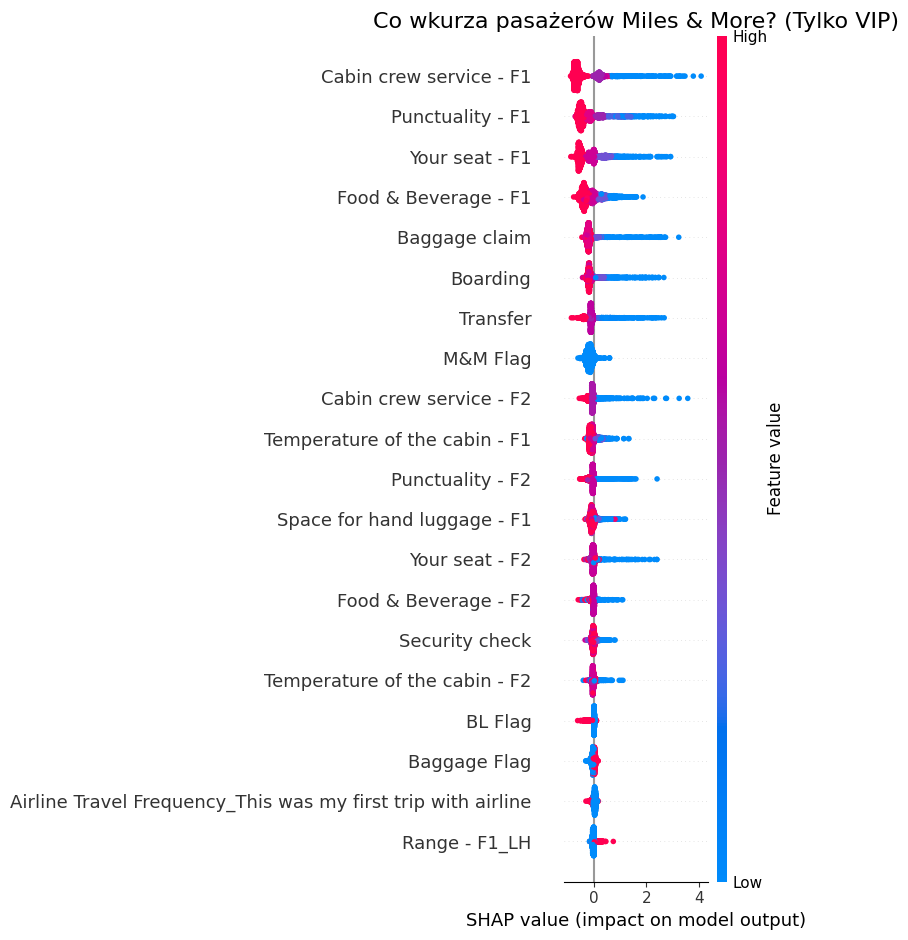


=== RANKING WAŻNOŚCI DLA MILES & MORE (TOP 15) ===
1. Cabin crew service - F1: 0.6349
2. Punctuality - F1: 0.4890
3. Your seat - F1: 0.4296
4. Food & Beverage - F1: 0.3399
5. Baggage claim: 0.2638
6. Boarding: 0.2503
7. Transfer: 0.2272
8. M&M Flag: 0.1662
9. Cabin crew service - F2: 0.1514
10. Temperature of the cabin - F1: 0.1284
11. Punctuality - F2: 0.1131
12. Space for hand luggage - F1: 0.1009
13. Your seat - F2: 0.0771
14. Food & Beverage - F2: 0.0620
15. Security check: 0.0602


In [19]:
# 1. Tworzymy maskę (filtr) dla członków Miles & More
# Zakładamy, że 1 oznacza "jest członkiem"
mask_vip = X_test_final['M&M Flag'] == 1

print(f"Analiza dla grupy Miles & More. Liczba pasażerów w tej grupie: {mask_vip.sum()}")

# 2. Filtrujemy dane X oraz wartości SHAP
# Wybieramy tylko te wiersze, gdzie maska jest True
X_vip = X_test_final[mask_vip]
shap_values_vip = shap_values[mask_vip]

# 3. Rysujemy wykres SHAP tylko dla tej grupy
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_vip, X_vip, show=False)
plt.title("Co wkurza pasażerów Miles & More? (Tylko VIP)", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Generujemy ranking liczbowy dla tej grupy
mean_shap_vip = np.abs(shap_values_vip).mean(axis=0)
vip_ranking = sorted(zip(X_vip.columns, mean_shap_vip), key=lambda x: x[1], reverse=True)

print("\n=== RANKING WAŻNOŚCI DLA MILES & MORE (TOP 15) ===")
for i, (name, value) in enumerate(vip_ranking[:15]):
    print(f"{i+1}. {name}: {value:.4f}")

=== ANALIZA SEGMENTU TRANSFEROWEGO ===
Liczba pasażerów w tej grupie: 5637


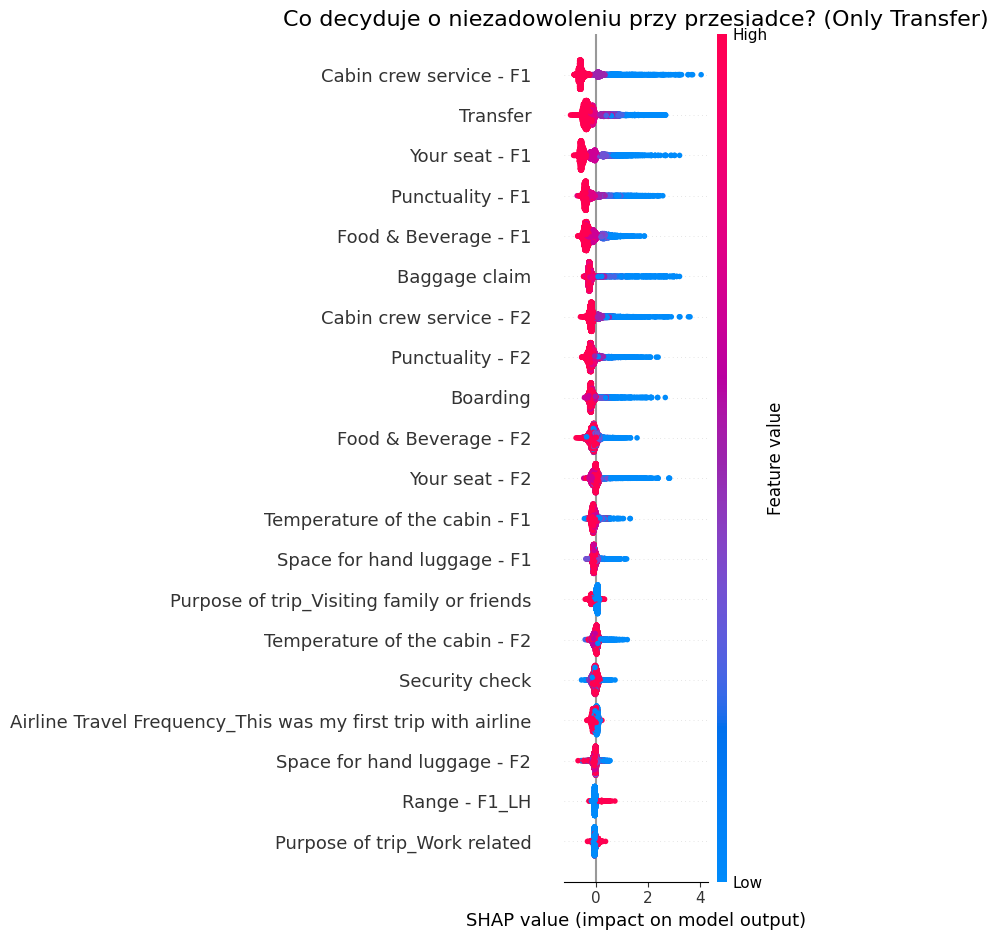

In [20]:
# Wykres SHap tylko dla paxów przesiadkowych

# 1. Tworzymy maskę dla pasażerów transferowych
# Zakładamy, że Transfer Flag = 1 oznacza przesiadkę
mask_transfer = X_test_final['Transfer Flag'] == 1

print(f"=== ANALIZA SEGMENTU TRANSFEROWEGO ===")
print(f"Liczba pasażerów w tej grupie: {mask_transfer.sum()}")

# 2. Filtrujemy dane i wartości SHAP
X_transfer = X_test_final[mask_transfer]
shap_values_transfer = shap_values[mask_transfer]

# 3. Wykres SHAP dla grupy transferowej
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_transfer, X_transfer, show=False)
plt.title("Co decyduje o niezadowoleniu przy przesiadce? (Only Transfer)", fontsize=16)
plt.tight_layout()
plt.show()

In [21]:
# Średni wpływ, maksymalny i proporcja dla paxów transferowych

# 1. filtrowanie tylko transferów
# Tworzymy maskę logiczną: True tam, gdzie pasażer miał przesiadkę
mask_transfer = X_test_final['Transfer Flag'] == 1

# Wyciągamy odpowiednie wiersze z macierzy SHAP i ze zbioru X
shap_values_transfer = shap_values[mask_transfer]
X_transfer_subset = X_test_final[mask_transfer]

print(f"Generowanie tabeli dla segmentu TRANSFER. Liczba pasażerów: {mask_transfer.sum()}")

# 2. obliczenia
mean_shap = np.abs(shap_values_transfer).mean(axis=0)
max_shap = np.abs(shap_values_transfer).max(axis=0)

df_transfer = pd.DataFrame({
    'Feature': X_transfer_subset.columns,
    'Mean_Impact (Transfer)': mean_shap,
    'Max_Impact (Transfer)': max_shap
})

# Obliczamy Niche Ratio
# Jeśli Max jest 0 (bardzo rzadkie), wstawiamy NaN żeby nie było błędu, ale SHAP raczej nie będzie zerem wszędzie
df_transfer['Niche_Ratio'] = df_transfer['Mean_Impact (Transfer)'] / df_transfer['Max_Impact (Transfer)']

# Sortujemy
df_transfer = df_transfer.sort_values(by='Mean_Impact (Transfer)', ascending=False).reset_index(drop=True)

# 3. formatowanie
styled_transfer = df_transfer.style.format({
    'Mean_Impact (Transfer)': '{:.4f}',
    'Max_Impact (Transfer)': '{:.4f}',
    'Niche_Ratio': '{:.4f}'
}).background_gradient(
    subset=['Mean_Impact (Transfer)'], cmap='Reds'
).background_gradient(
    subset=['Max_Impact (Transfer)'], cmap='Blues'
).background_gradient(
    subset=['Niche_Ratio'], cmap='Purples', vmin=0, vmax=0.2 
).set_caption("Ranking Ważności Zmiennych: Segment Transferowy")

styled_transfer

Generowanie tabeli dla segmentu TRANSFER. Liczba pasażerów: 5637


,Feature,Mean_Impact (Transfer),Max_Impact (Transfer),Niche_Ratio
0,Cabin crew service - F1,0.5567,4.0584,0.1372
1,Transfer,0.4221,2.6938,0.1567
2,Your seat - F1,0.4219,3.2283,0.1307
3,Punctuality - F1,0.3906,2.5817,0.1513
4,Food & Beverage - F1,0.3214,1.8747,0.1714
5,Baggage claim,0.3097,3.2268,0.0960
6,Cabin crew service - F2,0.2550,3.6300,0.0702
7,Punctuality - F2,0.2284,2.4022,0.0951
8,Boarding,0.2081,2.6775,0.0777
9,Food & Beverage - F2,0.1484,1.5895,0.0934


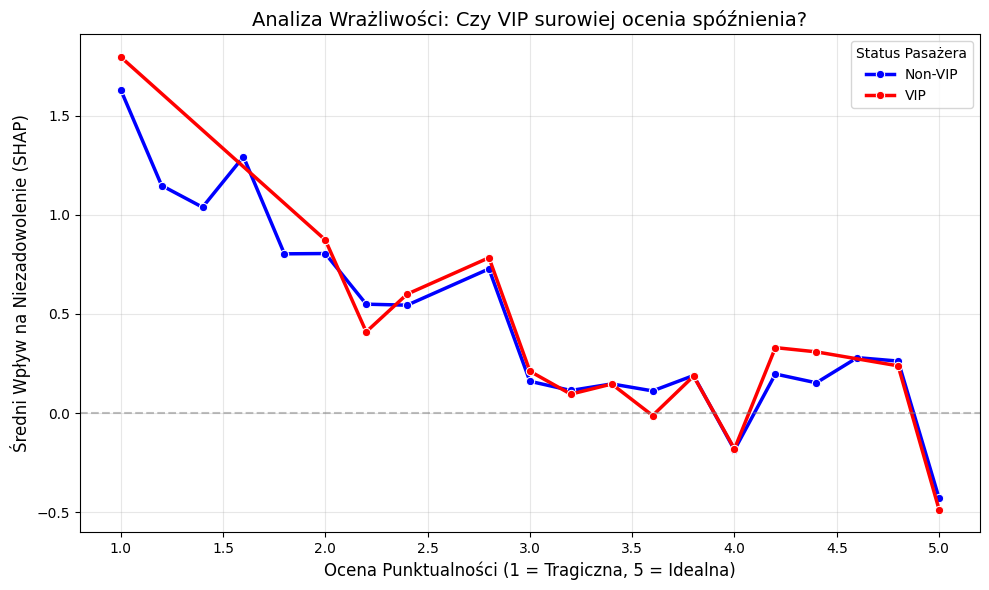

In [22]:
# Poprzedni wykres mało czytelny
# 1. Przygotowanie danych
# Znajdujemy indeks kolumny 'Punctuality - F1'
col_name = 'Punctuality - F1'
col_idx = X_test_final.columns.get_loc(col_name)

# Tworzymy tymczasową ramkę danych do wykresu
df_plot = pd.DataFrame({
    'Score': X_test_final[col_name],
    'VIP_Status': X_test_final['M&M Flag'].map({0: 'Non-VIP', 1: 'VIP'}),
    'SHAP_Value': shap_values[:, col_idx] # Wyciągamy wartości SHAP tylko dla tej cechy
})

# 2. Agregacja (Liczymy średni wpływ dla każdej grupy)
# To "wyczyści" wykres z tysięcy kropek
df_trend = df_plot.groupby(['Score', 'VIP_Status'])['SHAP_Value'].mean().reset_index()

# 3. Rysowanie wykresu liniowego
plt.figure(figsize=(10, 6))

# Używamy searborn do narysowania ładnych linii
sns.lineplot(
    data=df_trend, 
    x='Score', 
    y='SHAP_Value', 
    hue='VIP_Status', 
    palette={'VIP': 'red', 'Non-VIP': 'blue'},
    marker='o', # Kropki na załamaniach
    linewidth=2.5
)

# Linia pozioma 0 (neutralność)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Opisy
plt.title("Analiza Wrażliwości: Czy VIP surowiej ocenia spóźnienia?", fontsize=14)
plt.xlabel("Ocena Punktualności (1 = Tragiczna, 5 = Idealna)", fontsize=12)
plt.ylabel("Średni Wpływ na Niezadowolenie (SHAP)", fontsize=12)
plt.legend(title='Status Pasażera')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analiza dla pasażerów transferowych. Liczba próbek: 5637


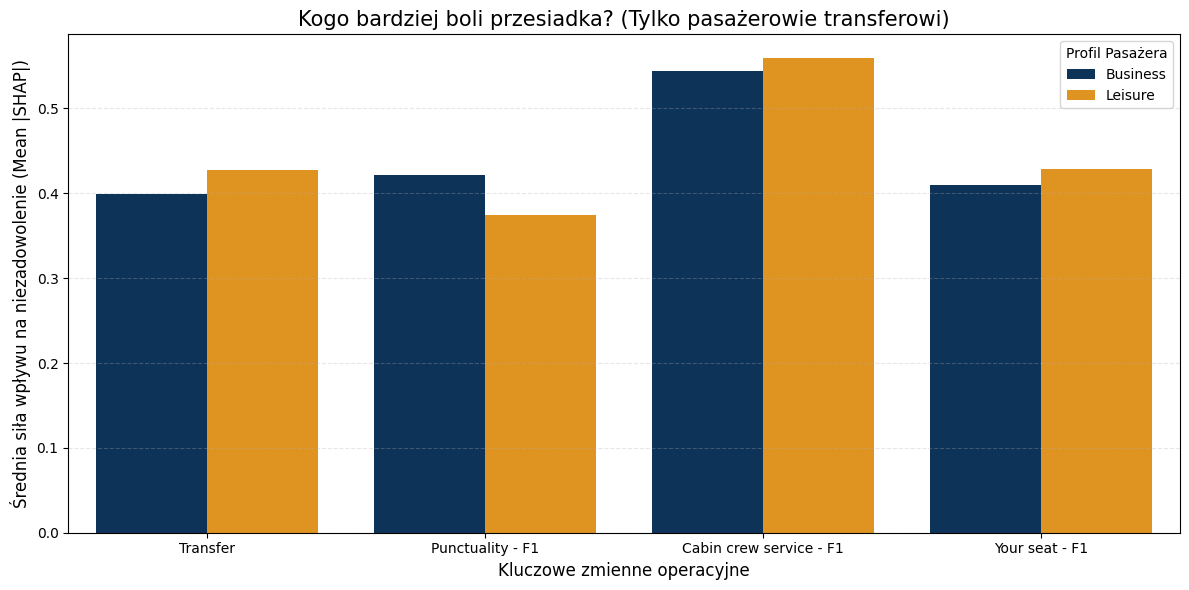

,Feature,Business,Leisure,Difference (Biz - Leisure)
0,Transfer,0.399175,0.428015,-0.028839
1,Punctuality - F1,0.421704,0.374109,0.047596
2,Cabin crew service - F1,0.544708,0.559442,-0.014734
3,Your seat - F1,0.409709,0.428877,-0.019168


In [23]:
# Dla pasażerów transferowych, wpływ na niezadowolenie topowych zmiennych w podziale na pax biznes i leasure

# 1. Filtrowanie: Bierzemy TYLKO pasażerów transferowych
mask_transfer = X_test_final['Transfer Flag'] == 1
X_trans = X_test_final[mask_transfer]
shap_trans = shap_values[mask_transfer]

print(f"Analiza dla pasażerów transferowych. Liczba próbek: {len(X_trans)}")

# 2. Definiowanie grup (Biznes vs Leisure) unikalnych dla tego zbioru
# Tworzymy nową kolumnę pomocniczą 'Passenger_Type'
passenger_type = []

# Iterujemy po wierszach (indeksy muszą być zresetowane lub używamy iloc w pętli, 
# ale szybciej wektorowo):

# Przygotujmy maski wewnątrz zbioru transferowego
is_work = X_trans['Purpose of trip_Work related'] == 1
is_tourism = X_trans['Purpose of trip_Tourism'] == 1
is_family = X_trans['Purpose of trip_Visiting family or friends'] == 1

# Przypisanie etykiet
# Tworzymy serię tekstową
types = pd.Series(['Other'] * len(X_trans), index=X_trans.index)
types[is_tourism | is_family] = 'Leisure (Tourist/Family)'
types[is_work] = 'Business'

# Filtrujemy, żeby usunąć "Other" (żeby wykres był czysty)
mask_valid_type = types != 'Other'
X_trans_final = X_trans[mask_valid_type]
shap_trans_final = shap_trans[mask_valid_type]
types_final = types[mask_valid_type]

# 3. Obliczanie średniego wpływu SHAP dla kluczowych zmiennych
# Interesują nas: Transfer, Punktualność, i może Komfort (Seat)
features_to_compare = ['Transfer', 'Punctuality - F1', 'Cabin crew service - F1', 'Your seat - F1']

results = []

for feature in features_to_compare:
    # Znajdź indeks kolumny w macierzy SHAP
    feat_idx = X_test_final.columns.get_loc(feature)
    
    # Wyciągnij wartości SHAP dla tej cechy
    shaps = np.abs(shap_trans_final[:, feat_idx]) # Bierzemy wartość bezwzględną (siłę wpływu)
    
    # Stwórz mały DataFrame do agregacji
    df_temp = pd.DataFrame({
        'Type': types_final.values,
        'SHAP_Impact': shaps
    })
    
    # Policz średnią dla każdej grupy
    agg = df_temp.groupby('Type')['SHAP_Impact'].mean()
    
    results.append({
        'Feature': feature,
        'Business': agg.get('Business', 0),
        'Leisure': agg.get('Leisure (Tourist/Family)', 0)
    })

df_results = pd.DataFrame(results)

# 4. Wizualizacja
df_melted = df_results.melt(id_vars='Feature', var_name='Passenger Segment', value_name='Mean |SHAP| Impact')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Feature', y='Mean |SHAP| Impact', hue='Passenger Segment', palette={'Business': '#003366', 'Leisure': '#FF9900'})

plt.title("Kogo bardziej boli przesiadka? (Tylko pasażerowie transferowi)", fontsize=15)
plt.ylabel("Średnia siła wpływu na niezadowolenie (Mean |SHAP|)", fontsize=12)
plt.xlabel("Kluczowe zmienne operacyjne", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Profil Pasażera')

plt.tight_layout()
plt.show()

# Wyświetlenie tabeli z liczbami
df_results['Difference (Biz - Leisure)'] = df_results['Business'] - df_results['Leisure']
df_results

In [24]:
# F1 (Dolot)
print("--- F1 (Dolot) ---")
cols_f1 = ['Delay - F1_Bardzo opóźniony', 'Delay - F1_Lekko opóźniony', 'Delay - F1_Nie opóźniony']
print(X_test_final[cols_f1].sum())

# F2 (Odlot)
print("\n--- F2 (Odlot) ---")
cols_f2 = ['Delay - F2_Bardzo opóźniony', 'Delay - F2_Lekko opóźniony', 'Delay - F2_Nie opóźniony']
print(X_test_final[cols_f2].sum())

--- F1 (Dolot) ---
Delay - F1_Bardzo opóźniony      347
Delay - F1_Lekko opóźniony      2144
Delay - F1_Nie opóźniony       10816
dtype: int64

--- F2 (Odlot) ---
Delay - F2_Bardzo opóźniony     140
Delay - F2_Lekko opóźniony     1057
Delay - F2_Nie opóźniony       4440
dtype: int64


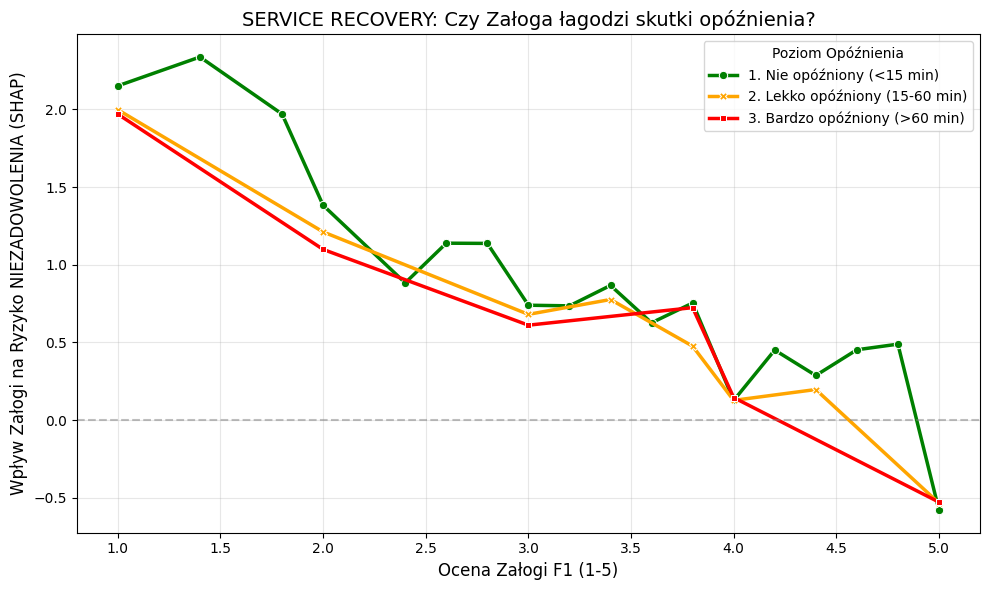

In [25]:
# 1. Filtrowanie (Tylko Transfery)
mask_transfer = X_test_final['Transfer Flag'] == 1
X_trans = X_test_final[mask_transfer]
shap_trans = shap_values[mask_transfer]

# 2. Odtwarzanie kategorii opóźnienia z One-Hot Encoding
# Tworzymy nową kolumnę 'Delay_Category'
delay_cats = []

# Pobieramy indeksy kolumn, żeby było szybciej
col_idx_none = X_test_final.columns.get_loc("Delay - F1_Nie opóźniony")
col_idx_light = X_test_final.columns.get_loc("Delay - F1_Lekko opóźniony")
col_idx_heavy = X_test_final.columns.get_loc("Delay - F1_Bardzo opóźniony")

# Iterujemy po wierszach (na podzbiorze transferowym)
# Uwaga: Zakładamy, że kategorie się wykluczają.
# Pobieramy wartości jako numpy array dla wydajności
data_vals = X_trans.values

for i in range(len(data_vals)):
    if data_vals[i, col_idx_heavy] == 1:
        delay_cats.append("3. Bardzo opóźniony (>60 min)")
    elif data_vals[i, col_idx_light] == 1:
        delay_cats.append("2. Lekko opóźniony (15-60 min)")
    else:
        # Zakładamy, że reszta to 'Nie opóźniony' (lub explicit check kolumny 'Nie opóźniony')
        delay_cats.append("1. Nie opóźniony (<15 min)")

# 3. Przygotowanie danych do wykresu
# Interesuje nas wpływ samej Załogi (Cabin Crew F1)
cc_col_name = "Cabin crew service - F1"
cc_col_idx = X_test_final.columns.get_loc(cc_col_name)

df_plot = pd.DataFrame({
    'Crew_Rating': X_trans[cc_col_name].values,
    'Delay_Category': delay_cats,
    'Crew_SHAP': shap_trans[:, cc_col_idx]  # Wartość SHAP dla Załogi
})

# Agregacja średniej
df_trend = df_plot.groupby(['Crew_Rating', 'Delay_Category'])['Crew_SHAP'].mean().reset_index()

# 4. Rysowanie wykresu
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_trend,
    x='Crew_Rating',
    y='Crew_SHAP',
    hue='Delay_Category',
    style='Delay_Category',
    markers=True,
    dashes=False,
    palette=["green", "orange", "red"], 
    linewidth=2.5
)

plt.ylabel("Wpływ Załogi na Ryzyko NIEZADOWOLENIA (SHAP)", fontsize=12)

plt.title("SERVICE RECOVERY: Czy Załoga łagodzi skutki opóźnienia?", fontsize=14)
plt.xlabel("Ocena Załogi F1 (1-5)", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend(title='Poziom Opóźnienia')

plt.tight_layout()
plt.show()

<Figure size 1000x700 with 0 Axes>

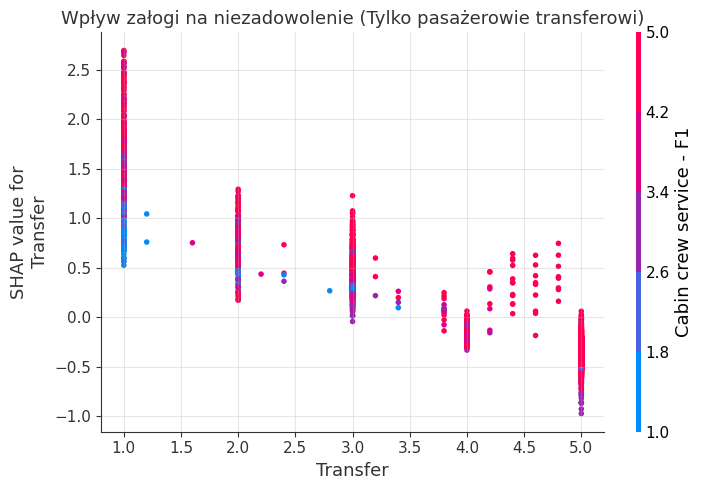

In [26]:
#W warunkach krytycznej niewydolności procesu transferowego (bardzo niska ocena transferu), 
#wysoka jakość obsługi pokładowej traci wpływ na ogólną satysfakcję pasażera.

# 1. Tworzymy "maskę" - szukamy wierszy, gdzie pasażer jest transferowy
# Zakładam, że X_test_final to pandas DataFrame.
transfer_mask = X_test_final['Transfer Flag'] == 1

# 2. Filtrujemy dane wejściowe (cechy)
X_test_transfer_only = X_test_final[transfer_mask]

# 3. Filtrujemy wartości SHAP
# shap_values to zazwyczaj numpy array, więc maska logiczna zadziała tak samo
shap_values_transfer_only = shap_values[transfer_mask]

# 4. Rysujemy wykres Dependence Plot TYLKO dla pasażerów transferowych
plt.figure(figsize=(10, 7))

shap.dependence_plot(
    ind="Transfer",      # Oś X: Ocena załogi na dolocie
    shap_values=shap_values_transfer_only, # Wartości SHAP tylko dla transferów
    features=X_test_transfer_only,      # Cechy tylko dla transferów
    interaction_index="Cabin crew service - F1",       # Kolor kropek: Ocena samego procesu Transferu
    show=False,
    title="Wpływ załogi na niezadowolenie (Tylko pasażerowie transferowi)"
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x700 with 0 Axes>

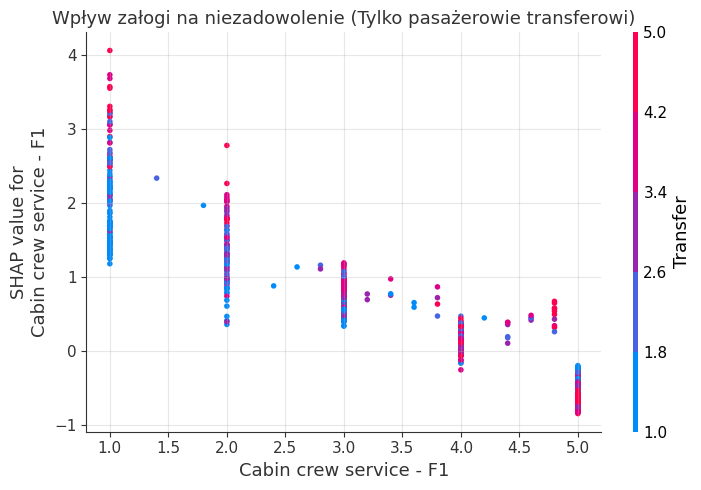

In [27]:
# 1. Tworzymy "maskę" - szukamy wierszy, gdzie pasażer jest transferowy
# Zakładam, że X_test_final to pandas DataFrame.
transfer_mask = X_test_final['Transfer Flag'] == 1

# 2. Filtrujemy dane wejściowe (cechy)
X_test_transfer_only = X_test_final[transfer_mask]

# 3. Filtrujemy wartości SHAP
# shap_values to zazwyczaj numpy array, więc maska logiczna zadziała tak samo
shap_values_transfer_only = shap_values[transfer_mask]

# 4. Rysujemy wykres Dependence Plot TYLKO dla pasażerów transferowych
plt.figure(figsize=(10, 7))

shap.dependence_plot(
    ind="Cabin crew service - F1",      # Oś X: Ocena załogi na dolocie
    shap_values=shap_values_transfer_only, # Wartości SHAP tylko dla transferów
    features=X_test_transfer_only,      # Cechy tylko dla transferów
    interaction_index="Transfer",       # Kolor kropek: Ocena samego procesu Transferu
    show=False,
    title="Wpływ załogi na niezadowolenie (Tylko pasażerowie transferowi)"
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

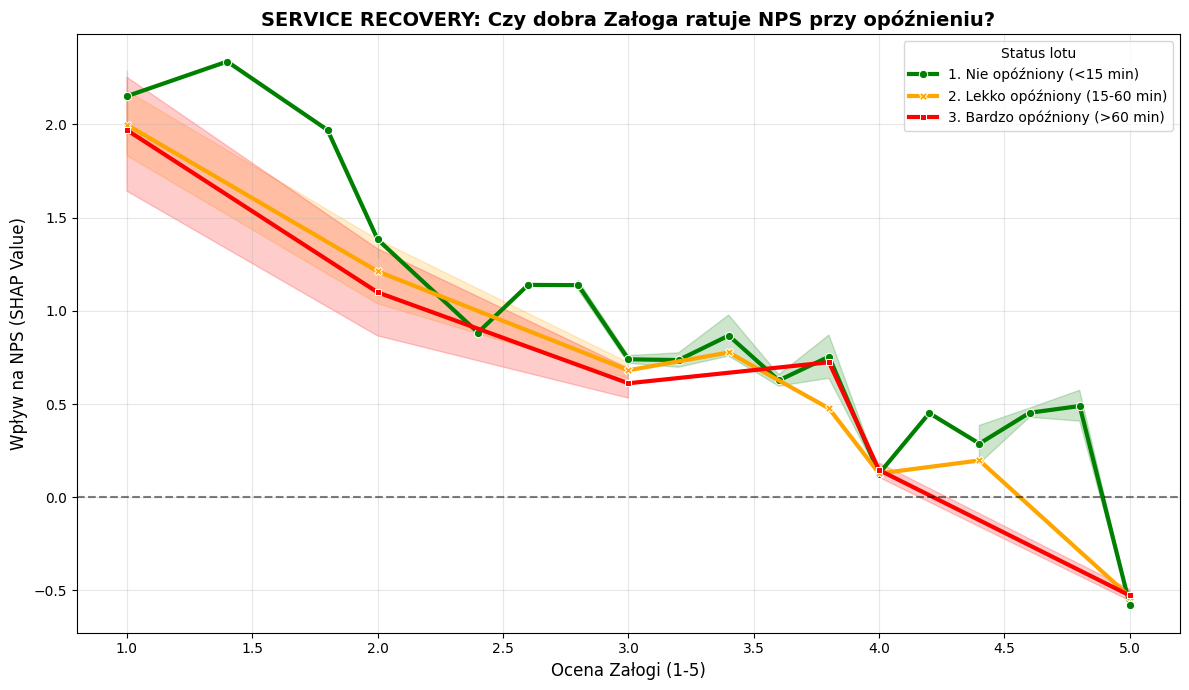

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Filtrowanie (Tylko Transfery) - tu bez zmian
mask_transfer = X_test_final['Transfer Flag'] == 1
X_trans = X_test_final[mask_transfer]
shap_trans = shap_values[mask_transfer]

# 2. Odtwarzanie kategorii (VECTORIZED - 100x szybsze niż pętla for)
# Definiujemy kolumny opóźnień
delay_cols = [
    'Delay - F1_Nie opóźniony', 
    'Delay - F1_Lekko opóźniony', 
    'Delay - F1_Bardzo opóźniony'
]

# Mapowanie nazw kolumn na ładne etykiety
labels_map = {
    'Delay - F1_Nie opóźniony': '1. Nie opóźniony (<15 min)',
    'Delay - F1_Lekko opóźniony': '2. Lekko opóźniony (15-60 min)',
    'Delay - F1_Bardzo opóźniony': '3. Bardzo opóźniony (>60 min)'
}

# idxmax znajduje kolumnę z jedynką dla każdego wiersza błyskawicznie
delay_cats = X_trans[delay_cols].idxmax(axis=1).map(labels_map)

# 3. Przygotowanie danych (Surowe dane, BEZ groupby!)
cc_col_name = "Cabin crew service - F1"
cc_col_idx = X_test_final.columns.get_loc(cc_col_name)

df_plot = pd.DataFrame({
    'Crew_Rating': X_trans[cc_col_name].values,
    'Delay_Category': delay_cats.values,
    'Crew_SHAP': shap_trans[:, cc_col_idx]  # Wartość SHAP
})

# Dodajemy minimalny jitter (szum) do oceny, żeby kropki (jeśli włączone) się nie nakładały
# Ale dla lineplota to nie jest konieczne, chyba że chcesz pokazać markers=True w ładny sposób

# 4. Rysowanie
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=df_plot,      # WRZUCAMY SUROWE DANE
    x='Crew_Rating',
    y='Crew_SHAP',
    hue='Delay_Category',
    style='Delay_Category',
    hue_order=[        # Wymuszamy kolejność, żeby kolory pasowały logicznie
        '1. Nie opóźniony (<15 min)', 
        '2. Lekko opóźniony (15-60 min)', 
        '3. Bardzo opóźniony (>60 min)'
    ],
    palette=["green", "orange", "red"], 
    markers=True,
    dashes=False,
    linewidth=3,
    err_style="band",  # To rysuje cienie (przedział ufności 95%)
    ci=95              # Poziom ufności
)

plt.title("SERVICE RECOVERY: Czy dobra Załoga ratuje NPS przy opóźnieniu?", fontsize=14, fontweight='bold')
plt.ylabel("Wpływ na NPS (SHAP Value)", fontsize=12)
plt.xlabel("Ocena Załogi (1-5)", fontsize=12)

# Linia zero - granica między "pomaga" a "szkodzi"
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend(title='Status lotu')

plt.tight_layout()
plt.show()

--- WERYFIKACJA LICZEBNOŚCI (N) DLA IFE F1 ---
   Ocena IFE       Delay Status  Mean_SHAP  Count
0        1.0    Brak opóźnienia   0.472893     32
3        5.0    Brak opóźnienia  -0.163565    181
2        1.0  Lekkie opóźnienie   0.855744      2
5        5.0  Lekkie opóźnienie  -0.193889     23
1        1.0    Duże opóźnienie   0.452758      3
4        5.0    Duże opóźnienie  -0.124465     11
----------------------------------------------


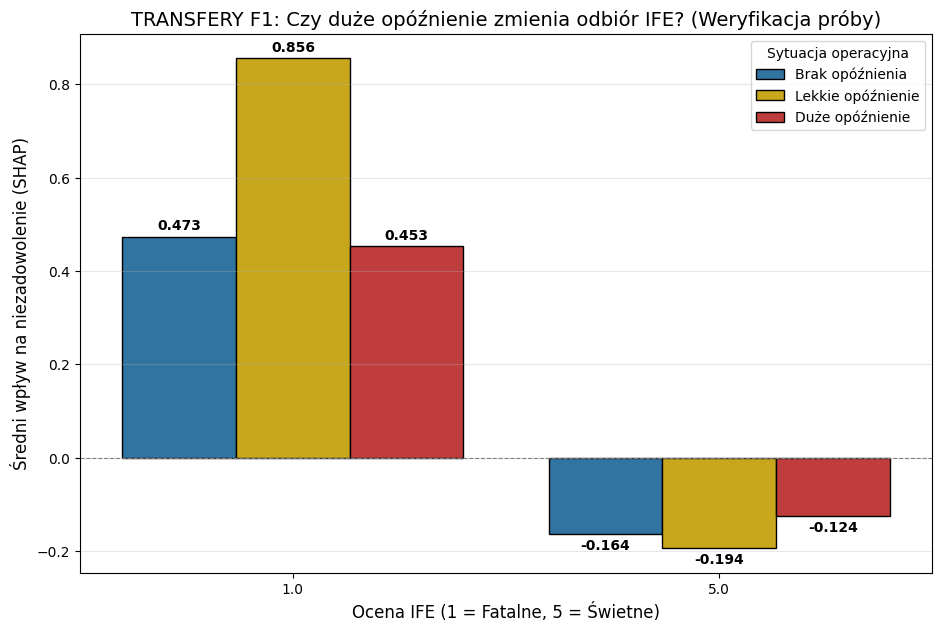

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Przygotowanie danych
mask_ife = (X_test_final['IFE Flag - F1'] == 1) & (X_test_final['Transfer Flag'] == 1)

X_test_ife = X_test_final[mask_ife].copy()

# Upewnij się, że shap_values jest odpowiednio sformatowane (dla klasy 1)
if isinstance(shap_values, list):
    shap_values_ife = shap_values[1][mask_ife]
else:
    shap_values_ife = shap_values[mask_ife]

# Wyciągamy wartości SHAP dla IFE
ife_col_index = X_test_final.columns.get_loc("IFE - F1")
y_shap = shap_values_ife[:, ife_col_index]

# 2. Tworzymy DataFrame roboczy
df_bar = pd.DataFrame({
    'Ocena IFE': X_test_ife['IFE - F1'],
    'SHAP Value': y_shap
})

# 3. Odtwarzamy kategorie opóźnień
conditions = [
    X_test_ife['Delay - F1_Nie opóźniony'] == 1,
    X_test_ife['Delay - F1_Lekko opóźniony'] == 1,
    X_test_ife['Delay - F1_Bardzo opóźniony'] == 1
]
choices = ['Brak opóźnienia', 'Lekkie opóźnienie', 'Duże opóźnienie']
df_bar['Delay Status'] = np.select(conditions, choices, default='Brak opóźnienia')

# 4. FILTROWANIE: Zostawiamy tylko oceny 1 i 5
df_extremes = df_bar[df_bar['Ocena IFE'].isin([1, 5])].copy()

# 5. Agregacja (średni SHAP + LICZEBNOŚĆ)
# Liczymy od razu count, żeby widzieć ile osób wpadło do kubka
stats = df_extremes.groupby(['Ocena IFE', 'Delay Status']).agg(
    Mean_SHAP=('SHAP Value', 'mean'),
    Count=('SHAP Value', 'count')
).reset_index()

# Sortowanie legendy
custom_order = ['Brak opóźnienia', 'Lekkie opóźnienie', 'Duże opóźnienie']
stats['Delay Status'] = pd.Categorical(stats['Delay Status'], categories=custom_order, ordered=True)
stats = stats.sort_values('Delay Status')

# Wyświetlenie tabeli w konsoli - TO JEST PRAWDA O DANYCH
print("--- WERYFIKACJA LICZEBNOŚCI (N) DLA IFE F1 ---")
print(stats)
print("----------------------------------------------")

# 6. Rysujemy Wykres Słupkowy
plt.figure(figsize=(11, 7))

ax = sns.barplot(
    data=stats,
    x='Ocena IFE',
    y='Mean_SHAP',
    hue='Delay Status',
    palette={'Brak opóźnienia': '#1f77b4', 'Lekkie opóźnienie': '#e6b800', 'Duże opóźnienie': '#d62728'},
    edgecolor='black'
)

# Dodajemy wartości liczbowe ORAZ liczebność (n) nad słupkami
for container in ax.containers:
    # Pobieramy etykietę z legendy, żeby dopasować dane
    label_status = container.get_label()
    
    # Tworzymy etykiety iterując po słupkach
    labels = []
    for val, x_coord in zip(container.datavalues, [rect.get_x() + rect.get_width() / 2 for rect in container]):
        # Znajdujemy odpowiednie n dla danej wysokości słupka (val) i statusu
        # To jest uproszczone dopasowanie, zakładamy spójność danych
        # Bezpieczniej pobrać ze stats
        match = stats[(stats['Delay Status'] == label_status) & (np.isclose(stats['Mean_SHAP'], val))]
        if not match.empty:
            n = match['Count'].iloc[0]
            labels.append(f'{val:.3f}\n(n={n})')
        else:
            labels.append(f'{val:.3f}')

    ax.bar_label(container, labels=labels, padding=3, fontsize=10, fontweight='bold')

plt.title('TRANSFERY F1: Czy duże opóźnienie zmienia odbiór IFE? (Weryfikacja próby)', fontsize=14)
plt.ylabel('Średni wpływ na niezadowolenie (SHAP)', fontsize=12)
plt.xlabel('Ocena IFE (1 = Fatalne, 5 = Świetne)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Sytuacja operacyjna')
plt.grid(axis='y', alpha=0.3)

plt.show()


=== ANALIZA DLA: TRANSFERY F1 (TYLKO GDY IFE BYŁO DOSTĘPNE) ===
Liczba pasażerów transferowych z dostępnym IFE: 574
Liczebności (n) w grupach:
         IFE Group      Punct Group  Mean_SHAP  Count
0  Negatywna (1-2)  Negatywna (1-2)   0.104902     20
1  Negatywna (1-2)  Pozytywna (4-5)   0.397053     55
2  Pozytywna (4-5)  Negatywna (1-2)  -0.261731     13
3  Pozytywna (4-5)  Pozytywna (4-5)  -0.180566    349


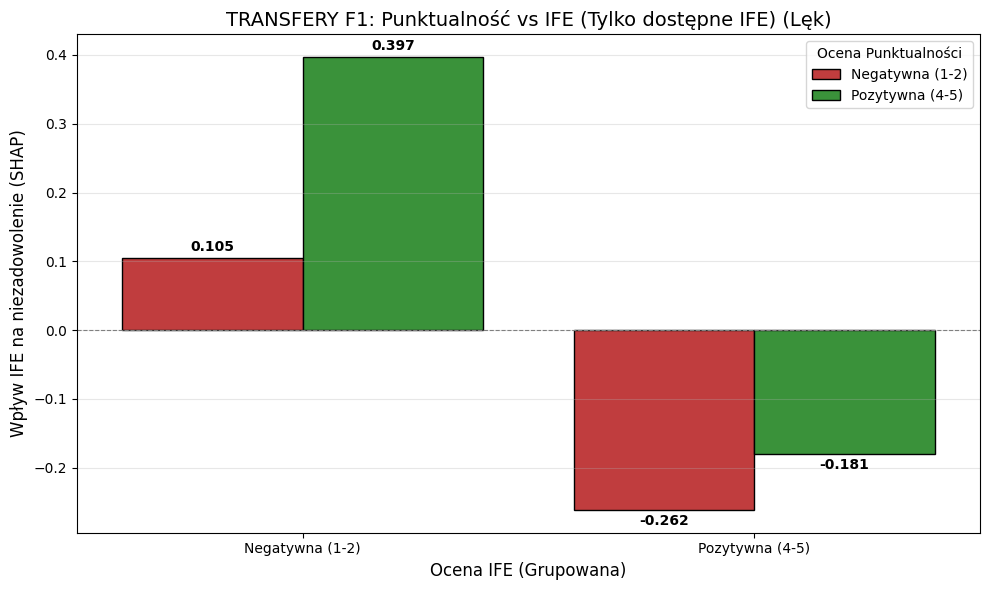


=== ANALIZA DLA: TRANSFERY F2 (TYLKO GDY IFE BYŁO DOSTĘPNE) ===
Liczba pasażerów transferowych z dostępnym IFE: 817
Liczebności (n) w grupach:
         IFE Group      Punct Group  Mean_SHAP  Count
0  Negatywna (1-2)  Negatywna (1-2)   0.315428     53
1  Negatywna (1-2)  Pozytywna (4-5)   0.340937     52
2  Pozytywna (4-5)  Negatywna (1-2)  -0.239808     30
3  Pozytywna (4-5)  Pozytywna (4-5)  -0.224022    474


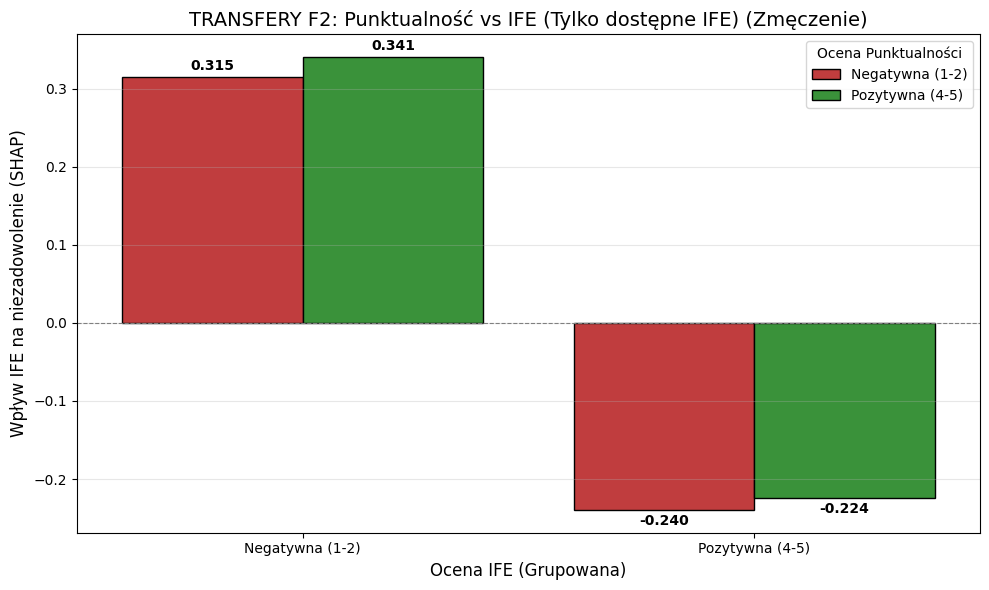

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def analyze_ife_vs_punctuality_final(segment, ife_rating_col, ife_flag_col, punct_rating_col, title_suffix):
    print(f"\n=== ANALIZA DLA: {segment} (TYLKO GDY IFE BYŁO DOSTĘPNE) ===")
    
    # 1. FILTROWANIE
    # Warunek 1: Pasażer Transferowy
    # Warunek 2: IFE było fizycznie dostępne (Flag == 1)
    mask = (X_test_final['Transfer Flag'] == 1) & (X_test_final[ife_flag_col] == 1)
    
    # Sprawdźmy, ilu pasażerów spełnia ten warunek
    print(f"Liczba pasażerów transferowych z dostępnym IFE: {mask.sum()}")
    
    if mask.sum() == 0:
        print("Brak danych spełniających kryteria.")
        return

    # Kopiujemy dane
    X_subset = X_test_final[mask].copy()

    # Wyciągamy odpowiednie SHAP values
    if isinstance(shap_values, list):
        shap_subset = shap_values[1][mask]
    else:
        shap_subset = shap_values[mask]

    # Wyciągamy wpływ (SHAP) zmiennej OCENY IFE
    ife_idx = X_test_final.columns.get_loc(ife_rating_col)
    y_shap = shap_subset[:, ife_idx]

    # 2. DataFrame roboczy
    df_work = pd.DataFrame({
        'Ocena IFE': X_subset[ife_rating_col],
        'Ocena Punct': X_subset[punct_rating_col],
        'SHAP Value': y_shap
    })

    # 3. grupowanie
    # Łączymy oceny 1 i 2 (Negatywne) oraz 4 i 5 (Pozytywne)
    # Ocenę 3 traktujemy jako neutralną i odrzucamy dla czystości obrazu
    def categorize_rating(val):
        if val <= 2: return 'Negatywna (1-2)'
        elif val >= 4: return 'Pozytywna (4-5)'
        else: return 'Neutralna (3)'

    df_work['IFE Group'] = df_work['Ocena IFE'].apply(categorize_rating)
    df_work['Punct Group'] = df_work['Ocena Punct'].apply(categorize_rating)

    # 4. odrzucenie środkowych kategorii
    mask_valid = (df_work['IFE Group'] != 'Neutralna (3)') & (df_work['Punct Group'] != 'Neutralna (3)')
    df_plot = df_work[mask_valid].copy()

    # 5. agregacja
    stats = df_plot.groupby(['IFE Group', 'Punct Group']).agg(
        Mean_SHAP=('SHAP Value', 'mean'),
        Count=('SHAP Value', 'count')
    ).reset_index()

    print(f"Liczebności (n) w grupach:")
    print(stats)


    if not stats.empty:
        plt.figure(figsize=(10, 6))
        
        # Kolory: Czerwony (Zła punktualność), Zielony (Dobra punktualność)
        colors = {'Negatywna (1-2)': '#d62728', 'Pozytywna (4-5)': '#2ca02c'}

        ax = sns.barplot(
            data=stats,
            x='IFE Group',
            y='Mean_SHAP',
            hue='Punct Group',
            palette=colors,
            edgecolor='black'
        )

        # Dodajemy etykiety wartości nad słupkami
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

        plt.title(f'{segment}: Punktualność vs IFE (Tylko dostępne IFE) {title_suffix}', fontsize=14)
        plt.ylabel('Wpływ IFE na niezadowolenie (SHAP)', fontsize=12)
        plt.xlabel('Ocena IFE (Grupowana)', fontsize=12)
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        plt.legend(title='Ocena Punktualności')
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Zbyt mało danych po odfiltrowaniu ocen neutralnych.")



# 1. F1 (Dolot) - sprawdzamy flagę F1
analyze_ife_vs_punctuality_final(
    segment="TRANSFERY F1",
    ife_rating_col="IFE - F1", 
    ife_flag_col="IFE Flag - F1",  # <--- TU JEST TEN WARUNEK
    punct_rating_col="Punctuality - F1",
)

# 2. F2 (Odlot) - sprawdzamy flagę F2
analyze_ife_vs_punctuality_final(
    segment="TRANSFERY F2",
    ife_rating_col="IFE - F2", 
    ife_flag_col="IFE Flag - F2",  # <--- TU JEST TEN WARUNEK
    punct_rating_col="Punctuality - F2",
)

--- WERYFIKACJA LICZEBNOŚCI (N) DLA IFE F2 ---
   Ocena IFE       Delay Status  Mean_SHAP  Count
0        1.0    Brak opóźnienia   0.641185     46
3        5.0    Brak opóźnienia  -0.182507    249
2        1.0  Lekkie opóźnienie   0.645562     16
5        5.0  Lekkie opóźnienie  -0.375531     70
1        1.0    Duże opóźnienie   0.549029      2
4        5.0    Duże opóźnienie  -0.466732     16
----------------------------------------------


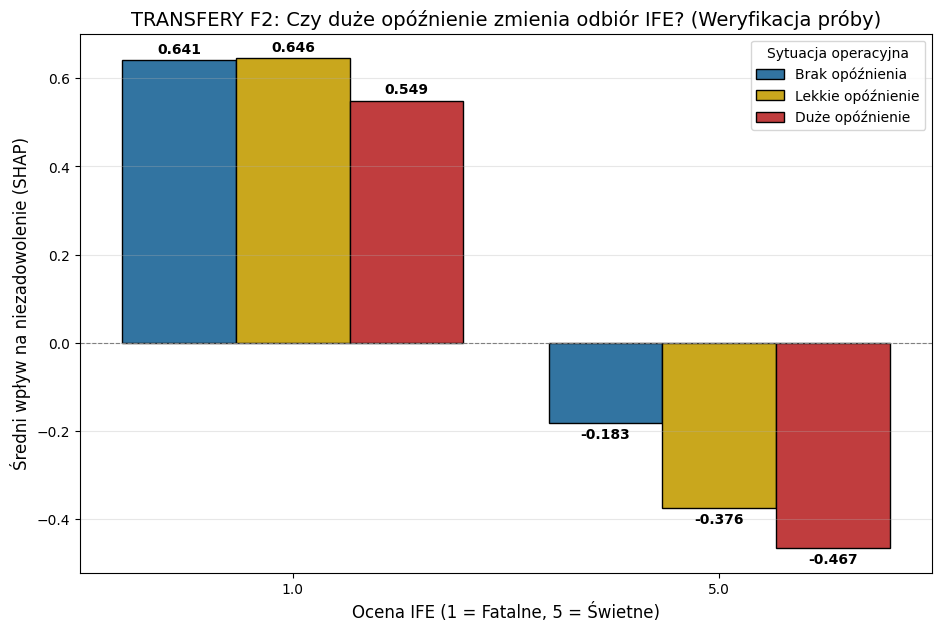

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Przygotowanie danych
# POPRAWKA: Dodano nawiasy przy warunkach logicznych (Python tego wymaga przy &)
mask_ife = (X_test_final['IFE Flag - F2'] == 1) & (X_test_final['Transfer Flag'] == 1)

X_test_ife = X_test_final[mask_ife].copy()

# Upewnij się, że shap_values jest odpowiednio sformatowane (dla klasy 1)
if isinstance(shap_values, list):
    shap_values_ife = shap_values[1][mask_ife]
else:
    shap_values_ife = shap_values[mask_ife]

# Wyciągamy wartości SHAP dla IFE
ife_col_index = X_test_final.columns.get_loc("IFE - F2")
y_shap = shap_values_ife[:, ife_col_index]

# 2. Tworzymy DataFrame roboczy
df_bar = pd.DataFrame({
    'Ocena IFE': X_test_ife['IFE - F2'],
    'SHAP Value': y_shap
})

# 3. Odtwarzamy kategorie opóźnień
conditions = [
    X_test_ife['Delay - F2_Nie opóźniony'] == 1,
    X_test_ife['Delay - F2_Lekko opóźniony'] == 1,
    X_test_ife['Delay - F2_Bardzo opóźniony'] == 1
]
choices = ['Brak opóźnienia', 'Lekkie opóźnienie', 'Duże opóźnienie']
df_bar['Delay Status'] = np.select(conditions, choices, default='Brak opóźnienia')

# 4. FILTROWANIE: Zostawiamy tylko oceny 1 i 5
df_extremes = df_bar[df_bar['Ocena IFE'].isin([1, 5])].copy()

# 5. Agregacja (średni SHAP + LICZEBNOŚĆ)
# Liczymy od razu count, żeby widzieć ile osób wpadło do kubka
stats = df_extremes.groupby(['Ocena IFE', 'Delay Status']).agg(
    Mean_SHAP=('SHAP Value', 'mean'),
    Count=('SHAP Value', 'count')
).reset_index()

# Sortowanie legendy
custom_order = ['Brak opóźnienia', 'Lekkie opóźnienie', 'Duże opóźnienie']
stats['Delay Status'] = pd.Categorical(stats['Delay Status'], categories=custom_order, ordered=True)
stats = stats.sort_values('Delay Status')

# Wyświetlenie tabeli w konsoli - TO JEST PRAWDA O DANYCH
print("--- WERYFIKACJA LICZEBNOŚCI (N) DLA IFE F2 ---")
print(stats)
print("----------------------------------------------")

# 6. Rysujemy Wykres Słupkowy
plt.figure(figsize=(11, 7))

ax = sns.barplot(
    data=stats,
    x='Ocena IFE',
    y='Mean_SHAP',
    hue='Delay Status',
    palette={'Brak opóźnienia': '#1f77b4', 'Lekkie opóźnienie': '#e6b800', 'Duże opóźnienie': '#d62728'},
    edgecolor='black'
)

# Dodajemy wartości liczbowe ORAZ liczebność (n) nad słupkami
for container in ax.containers:
    # Pobieramy etykietę z legendy, żeby dopasować dane
    label_status = container.get_label()
    
    # Tworzymy etykiety iterując po słupkach
    labels = []
    for val, x_coord in zip(container.datavalues, [rect.get_x() + rect.get_width() / 2 for rect in container]):
        # Znajdujemy odpowiednie n dla danej wysokości słupka (val) i statusu
        # To jest uproszczone dopasowanie, zakładamy spójność danych
        # Bezpieczniej pobrać ze stats
        match = stats[(stats['Delay Status'] == label_status) & (np.isclose(stats['Mean_SHAP'], val))]
        if not match.empty:
            n = match['Count'].iloc[0]
            labels.append(f'{val:.3f}\n(n={n})')
        else:
            labels.append(f'{val:.3f}')

    ax.bar_label(container, labels=labels, padding=3, fontsize=10, fontweight='bold')

plt.title('TRANSFERY F2: Czy duże opóźnienie zmienia odbiór IFE? (Weryfikacja próby)', fontsize=14)
plt.ylabel('Średni wpływ na niezadowolenie (SHAP)', fontsize=12)
plt.xlabel('Ocena IFE (1 = Fatalne, 5 = Świetne)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Sytuacja operacyjna')
plt.grid(axis='y', alpha=0.3)

plt.show()

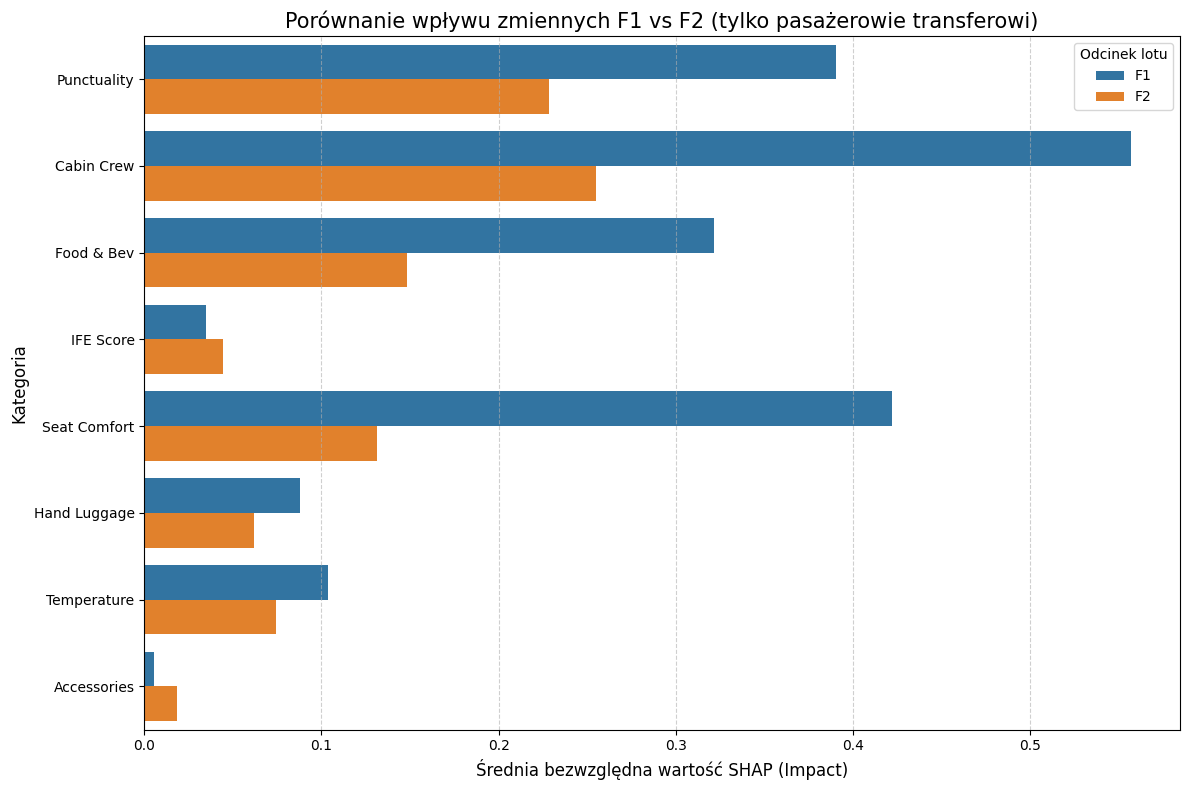

Różnice we wpływie (F1 vs F2):
Segment             F1        F2  Diff (F1 - F2) Dominant
Feature                                                  
Cabin Crew    0.556657  0.254967        0.301689       F1
Seat Comfort  0.421930  0.131445        0.290484       F1
Food & Bev    0.321368  0.148414        0.172954       F1
Punctuality   0.390602  0.228363        0.162239       F1
Temperature   0.103905  0.074076        0.029829       F1
Hand Luggage  0.088040  0.062138        0.025902       F1
IFE Score     0.034863  0.044220       -0.009357       F2
Accessories   0.005333  0.018677       -0.013343       F2


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definicja par zmiennych do porównania (na podstawie Twojej listy)
# Wybrałem te najbardziej kluczowe (oceny satysfakcji i flagi usług)
pairs = [
    ("Punctuality", "Punctuality - F1", "Punctuality - F2"),
    ("Cabin Crew", "Cabin crew service - F1", "Cabin crew service - F2"),
    ("Food & Bev", "Food & Beverage - F1", "Food & Beverage - F2"),
    ("IFE Score", "IFE - F1", "IFE - F2"),
    ("Seat Comfort", "Your seat - F1", "Your seat - F2"),
    ("Hand Luggage", "Space for hand luggage - F1", "Space for hand luggage - F2"),
    ("Temperature", "Temperature of the cabin - F1", "Temperature of the cabin - F2"),
    ("Accessories", "Accessories - F1", "Accessories - F2"),
]

# 2. Filtrowanie pasażerów transferowych
mask_transfer = X_test_final['Transfer Flag'] == 1
X_transfer = X_test_final[mask_transfer]

# UWAGA: Upewnij się, że shap_values jest w odpowiednim formacie.
# Jeśli masz model klasyfikacji binarnej, shap_values może być listą [shap_class_0, shap_class_1].
# Wtedy zazwyczaj interesuje nas klasa 1:
if isinstance(shap_values, list):
    shap_transfer = shap_values[1][mask_transfer]
else:
    shap_transfer = shap_values[mask_transfer]

# 3. Obliczenie średniego wpływu (Mean Absolute SHAP) dla par
comparison_data = []

for label, col_f1, col_f2 in pairs:
    # Pobieramy indeksy kolumn
    idx_f1 = X_test_final.columns.get_loc(col_f1)
    idx_f2 = X_test_final.columns.get_loc(col_f2)
    
    # Obliczamy średni moduł SHAP (siła wpływu)
    mean_shap_f1 = np.abs(shap_transfer[:, idx_f1]).mean()
    mean_shap_f2 = np.abs(shap_transfer[:, idx_f2]).mean()
    
    comparison_data.append({'Feature': label, 'Segment': 'F1', 'Mean |SHAP|': mean_shap_f1})
    comparison_data.append({'Feature': label, 'Segment': 'F2', 'Mean |SHAP|': mean_shap_f2})

df_comparison = pd.DataFrame(comparison_data)

# 4. Wizualizacja
plt.figure(figsize=(12, 8))
sns.barplot(data=df_comparison, x='Mean |SHAP|', y='Feature', hue='Segment', palette={'F1': '#1f77b4', 'F2': '#ff7f0e'})

plt.title('Porównanie wpływu zmiennych F1 vs F2 (tylko pasażerowie transferowi)', fontsize=15)
plt.xlabel('Średnia bezwzględna wartość SHAP (Impact)', fontsize=12)
plt.ylabel('Kategoria', fontsize=12)
plt.legend(title='Odcinek lotu')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Opcjonalnie: Wypisanie różnic procentowych
print("Różnice we wpływie (F1 vs F2):")
pivot_df = df_comparison.pivot(index='Feature', columns='Segment', values='Mean |SHAP|')
pivot_df['Diff (F1 - F2)'] = pivot_df['F1'] - pivot_df['F2']
pivot_df['Dominant'] = pivot_df.apply(lambda x: 'F1' if x['F1'] > x['F2'] else 'F2', axis=1)
print(pivot_df.sort_values('Diff (F1 - F2)', ascending=False))

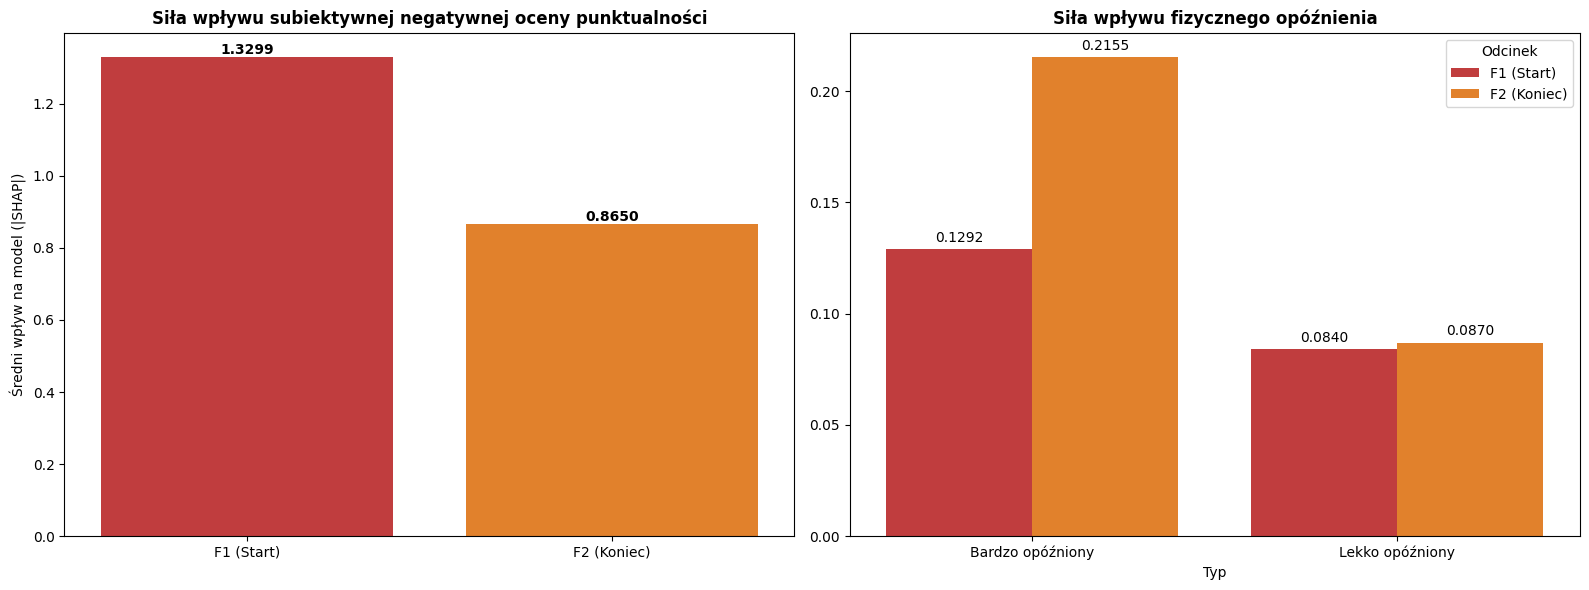

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- KONFIGURACJA DANYCH ---
# 1. Filtrujemy pasażerów transferowych
transfer_mask = X_test_final['Transfer Flag'] == 1
X_tr = X_test_final[transfer_mask]

# 2. Wybieramy odpowiednie SHAP values (dla klasy 1 przy klasyfikacji)
if isinstance(shap_values, list):
    shap_tr = shap_values[1][transfer_mask]
else:
    shap_tr = shap_values[transfer_mask]

# --- CZĘŚĆ 1: WYKRES SUBIEKTYWNY (OCENA PUNKTUALNOŚCI = 1) ---
col_punct_f1 = 'Punctuality - F1'
col_punct_f2 = 'Punctuality - F2'
idx_p_f1 = X_test_final.columns.get_loc(col_punct_f1)
idx_p_f2 = X_test_final.columns.get_loc(col_punct_f2)

# Filtrujemy tych, którzy dali ocenę 1
mask_score_1_f1 = X_tr[col_punct_f1] == 1
mask_score_1_f2 = X_tr[col_punct_f2] == 1

# Liczymy średni wpływ (Mean Absolute SHAP)
mean_impact_p_f1 = np.abs(shap_tr[mask_score_1_f1, idx_p_f1]).mean() if mask_score_1_f1.any() else 0
mean_impact_p_f2 = np.abs(shap_tr[mask_score_1_f2, idx_p_f2]).mean() if mask_score_1_f2.any() else 0

# --- CZĘŚĆ 2: WYKRES OBIEKTYWNY (FLAGI OPÓŹNIEŃ) ---
delay_features = [
    ("Bardzo opóźniony", "Delay - F1_Bardzo opóźniony", "Delay - F2_Bardzo opóźniony"),
    ("Lekko opóźniony", "Delay - F1_Lekko opóźniony", "Delay - F2_Lekko opóźniony")
]

delay_data = []
for label, col_f1, col_f2 in delay_features:
    idx_d_f1 = X_test_final.columns.get_loc(col_f1)
    idx_d_f2 = X_test_final.columns.get_loc(col_f2)
    
    # Filtrujemy tych, którzy faktycznie mieli opóźnienie (Value == 1)
    mask_delay_f1 = X_tr[col_f1] == 1
    mask_delay_f2 = X_tr[col_f2] == 1
    
    val_f1 = np.abs(shap_tr[mask_delay_f1, idx_d_f1]).mean() if mask_delay_f1.any() else 0
    val_f2 = np.abs(shap_tr[mask_delay_f2, idx_d_f2]).mean() if mask_delay_f2.any() else 0
    
    delay_data.append({'Typ': label, 'Odcinek': 'F1 (Start)', 'Impact': val_f1})
    delay_data.append({'Typ': label, 'Odcinek': 'F2 (Koniec)', 'Impact': val_f2})

df_delay = pd.DataFrame(delay_data)

# --- RYSOWANIE WYKRESÓW ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Ocena Punctuality = 1
sns.barplot(x=['F1 (Start)', 'F2 (Koniec)'], y=[mean_impact_p_f1, mean_impact_p_f2], 
            palette=['#d62728', '#ff7f0e'], ax=axes[0])
axes[0].set_title('Siła wpływu subiektywnej negatywnej oceny punktualności', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Średni wpływ na model (|SHAP|)')
for i, v in enumerate([mean_impact_p_f1, mean_impact_p_f2]):
    axes[0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Wykres 2: Fakt Opóźnienia
sns.barplot(data=df_delay, x='Typ', y='Impact', hue='Odcinek', 
            palette={'F1 (Start)': '#d62728', 'F2 (Koniec)': '#ff7f0e'}, ax=axes[1])
axes[1].set_title('Siła wpływu fizycznego opóźnienia', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

In [34]:
# --- ANALIZA LICZEBNOŚCI (N) ---

print("=== LICZEBNOŚCI DLA ANALIZY PUNKTUALNOŚCI I OPÓŹNIEŃ ===")

# 1. Subiektywne (Ocena = 1)
print(f"\n[Subiektywna Ocena 1]:")
print(f"  F1 (Start):  n = {mask_score_1_f1.sum()}")
print(f"  F2 (Koniec): n = {mask_score_1_f2.sum()}")

# 2. Obiektywne (Flagi opóźnień)
print(f"\n[Obiektywne Opóźnienie]:")
for label, col_f1, col_f2 in delay_features:
    n_f1 = X_tr[col_f1].sum()
    n_f2 = X_tr[col_f2].sum()
    print(f"  {label}:")
    print(f"    F1 (Start):  n = {n_f1}")
    print(f"    F2 (Koniec): n = {n_f2}")

# Dodatkowo: Procentowy udział w całym segmencie transferowym
total_transfer = len(X_tr)
print(f"\nCałkowita liczba pasażerów transferowych: {total_transfer}")

=== LICZEBNOŚCI DLA ANALIZY PUNKTUALNOŚCI I OPÓŹNIEŃ ===

[Subiektywna Ocena 1]:
  F1 (Start):  n = 309
  F2 (Koniec): n = 311

[Obiektywne Opóźnienie]:
  Bardzo opóźniony:
    F1 (Start):  n = 94
    F2 (Koniec): n = 140
  Lekko opóźniony:
    F1 (Start):  n = 780
    F2 (Koniec): n = 1057

Całkowita liczba pasażerów transferowych: 5637


In [35]:
"""
Na podstawie powyższej analizy SHAP (dla pasażerów transferowych) zidentyfikowano dwa kluczowe mechanizmy
wpływające na niezadowolenie klientów, które zależą od etapu podróży:

1. 
   * Wynik: Subiektywna ocena "1" z punktualności na F1 ma drastycznie wyższy wpływ na 
     niezadowolenie (SHAP ~1.33) niż na F2 (SHAP ~0.86), mimo że fizyczne opóźnienie waży tu mniej.
   * Przyczyna: Pasażer na pierwszym locie nie ocenia tylko czasu, ale ryzyko przesiadki. Poczucie, że 
     "jest niepunktualnie", wyzwala stres o utratę przesiadki i bagażu.
   * Na locie 1 kluczowa więc jest komunikacja

2. 
   * Wynik: Fizyczne "Bardzo duże opóźnienie" ma większą wagę na F2 (SHAP ~0.21) niż na F1 (SHAP ~0.13).
   * Przyczyna: Na ostatnim odcinku stres znika, pojawia się zmęczenie z podróży
     Opóźnienie tutaj to czysta, fizyczna strata prywatnego czasu, której nic nie łagodzi 
     (brak opieki linii, bo podróż się kończy).

To kolejny argument za rozwojem obsługi nieregularności
"""

'\nNa podstawie powyższej analizy SHAP (dla pasażerów transferowych) zidentyfikowano dwa kluczowe mechanizmy\nwpływające na niezadowolenie klientów, które zależą od etapu podróży:\n\n1. \n   * Wynik: Subiektywna ocena "1" z punktualności na F1 ma drastycznie wyższy wpływ na \n     niezadowolenie (SHAP ~1.33) niż na F2 (SHAP ~0.86), mimo że fizyczne opóźnienie waży tu mniej.\n   * Przyczyna: Pasażer na pierwszym locie nie ocenia tylko czasu, ale ryzyko przesiadki. Poczucie, że \n     "jest niepunktualnie", wyzwala stres o utratę przesiadki i bagażu.\n   * Na locie 1 kluczowa więc jest komunikacja\n\n2. \n   * Wynik: Fizyczne "Bardzo duże opóźnienie" ma większą wagę na F2 (SHAP ~0.21) niż na F1 (SHAP ~0.13).\n   * Przyczyna: Na ostatnim odcinku stres znika, pojawia się zmęczenie z podróży\n     Opóźnienie tutaj to czysta, fizyczna strata prywatnego czasu, której nic nie łagodzi \n     (brak opieki linii, bo podróż się kończy).\n\nTo kolejny argument za rozwojem obsługi nieregularności\n'

DEBUG: Całkowita liczba opóźnionych pasażerów transferowych: 874

--- TABELA WYNIKÓW (SPRAWDŹ CZY TUTAJ N JEST RÓŻNE) ---
          Klasa  Mean_SHAP  Count
0  Business (C)   0.092065     64
1   Economy (Y)   0.097278    804
2   Premium (P)   0.073541      6
--------------------------------------------------------



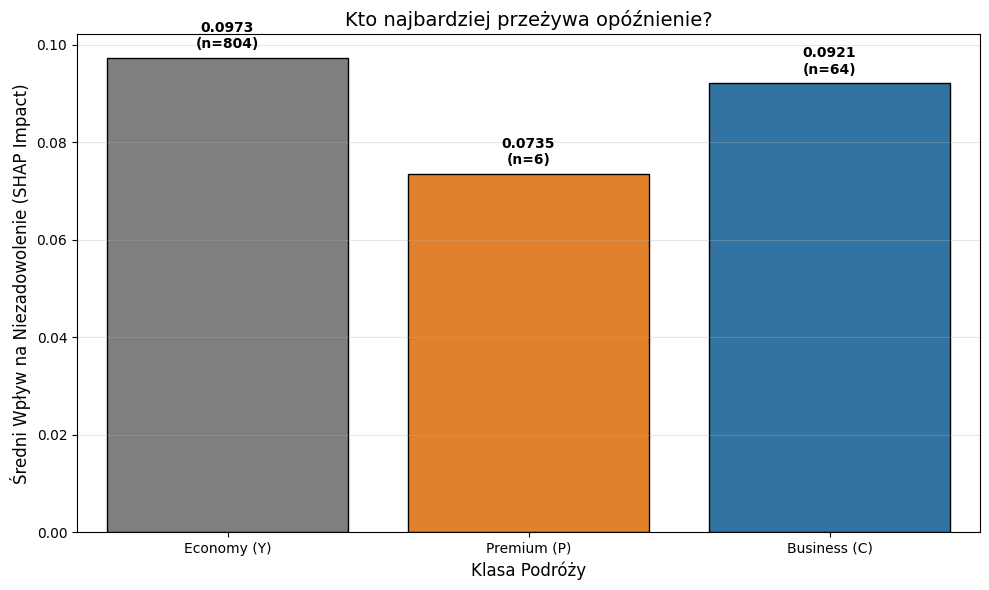

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. PRZYGOTOWANIE DANYCH (Bez zmian) ---
mask_transfer = X_test_final['Transfer Flag'] == 1
X_tr = X_test_final[mask_transfer]

if isinstance(shap_values, list):
    shap_tr = shap_values[1][mask_transfer]
else:
    shap_tr = shap_values[mask_transfer]

col_delay_light = "Delay - F1_Lekko opóźniony"
col_delay_heavy = "Delay - F1_Bardzo opóźniony"
idx_light = X_test_final.columns.get_loc(col_delay_light)
idx_heavy = X_test_final.columns.get_loc(col_delay_heavy)

# Filtrujemy "Jakiekolwiek opóźnienie"
mask_any_delay = (X_tr[col_delay_light] == 1) | (X_tr[col_delay_heavy] == 1)
X_delayed = X_tr[mask_any_delay]
shap_delayed = shap_tr[mask_any_delay]

print(f"DEBUG: Całkowita liczba opóźnionych pasażerów transferowych: {len(X_delayed)}")

# --- 2. PRZYPISANIE KLASY ---
results = []
for i in range(len(X_delayed)):
    pax_row = X_delayed.iloc[i]
    # Sprawdzamy klasę - domyślnie "Inne" jeśli nic nie pasuje
    pax_class = "Inne" 
    
    if pax_row['Cabin Class - F1_Y'] == 1:
        pax_class = "Economy (Y)"
    elif pax_row['Cabin Class - F1_P'] == 1:
        pax_class = "Premium (P)"
    elif pax_row['Cabin Class - F1_C'] == 1:
        pax_class = "Business (C)"
    
    impact = np.abs(shap_delayed[i, idx_light]) + np.abs(shap_delayed[i, idx_heavy])
    results.append({'Klasa': pax_class, 'SHAP Impact': impact})

df_results = pd.DataFrame(results)

# --- 3. WERYFIKACJA DANYCH (To pokaże prawdę w konsoli) ---
print("\n--- TABELA WYNIKÓW (SPRAWDŹ CZY TUTAJ N JEST RÓŻNE) ---")
summary = df_results.groupby('Klasa').agg(
    Mean_SHAP=('SHAP Impact', 'mean'),
    Count=('SHAP Impact', 'count')
).reset_index()
print(summary)
print("--------------------------------------------------------\n")

# --- 4. BEZPIECZNA WIZUALIZACJA ---
if not df_results.empty:
    # Ustalamy kolejność sortowania
    order_list = ["Economy (Y)", "Premium (P)", "Business (C)"]
    # Filtrujemy order_list, żeby zostały tylko te klasy, które faktycznie są w danych
    existing_classes = df_results['Klasa'].unique()
    final_order = [x for x in order_list if x in existing_classes]
    
    # Jeśli pojawiła się klasa "Inne", dodajemy ją na koniec
    if "Inne" in existing_classes:
        final_order.append("Inne")

    plt.figure(figsize=(10, 6))
    colors = {'Economy (Y)': '#7f7f7f', 'Premium (P)': '#ff7f0e', 'Business (C)': '#1f77b4', 'Inne': '#999999'}
    
    ax = sns.barplot(
        data=df_results,
        x='Klasa',
        y='SHAP Impact',
        order=final_order, # Wymuszamy kolejność
        palette=colors,
        errorbar=None, # Wyłączamy linię błędu dla czytelności
        edgecolor='black'
    )

    # --- POPRAWIONE ETYKIETOWANIE (Słownik zamiast indeksów) ---
    # Tworzymy słownik { "Economy (Y)": 150, "Business (C)": 20 ... }
    counts_dict = summary.set_index('Klasa')['Count'].to_dict()
    means_dict = summary.set_index('Klasa')['Mean_SHAP'].to_dict()

    # Iterujemy po słupkach na wykresie
    for i, p in enumerate(ax.patches):
        # Pobieramy nazwę klasy z osi X dla tego konkretnego słupka
        # To jest najbezpieczniejsza metoda
        if i < len(final_order): # Zabezpieczenie
            class_name = final_order[i]
            
            # Pobieramy n i średnią ze słownika
            n_val = counts_dict.get(class_name, 0)
            mean_val = means_dict.get(class_name, 0)
            
            # Wypisujemy
            label_text = f'{mean_val:.4f}\n(n={n_val})'
            
            ax.annotate(label_text, 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', 
                        xytext=(0, 5), 
                        textcoords='offset points',
                        fontweight='bold')

    plt.title('Kto najbardziej przeżywa opóźnienie?', fontsize=14)
    plt.ylabel('Średni Wpływ na Niezadowolenie (SHAP Impact)', fontsize=12)
    plt.xlabel('Klasa Podróży', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("Brak danych - żaden pasażer transferowy nie był opóźniony.")

DEBUG: Liczba opóźnionych pasażerów transferowych: 874

--- WERYFIKACJA LICZEBNOŚCI (N) ---
                      Grupa  Mean_SHAP  Count
0    Debiutant (First Trip)   0.097255    453
1  Lojalny (Frequent Flyer)   0.094445     52
2      Okazjonalny (Yearly)   0.097342    351
-------------------------------------



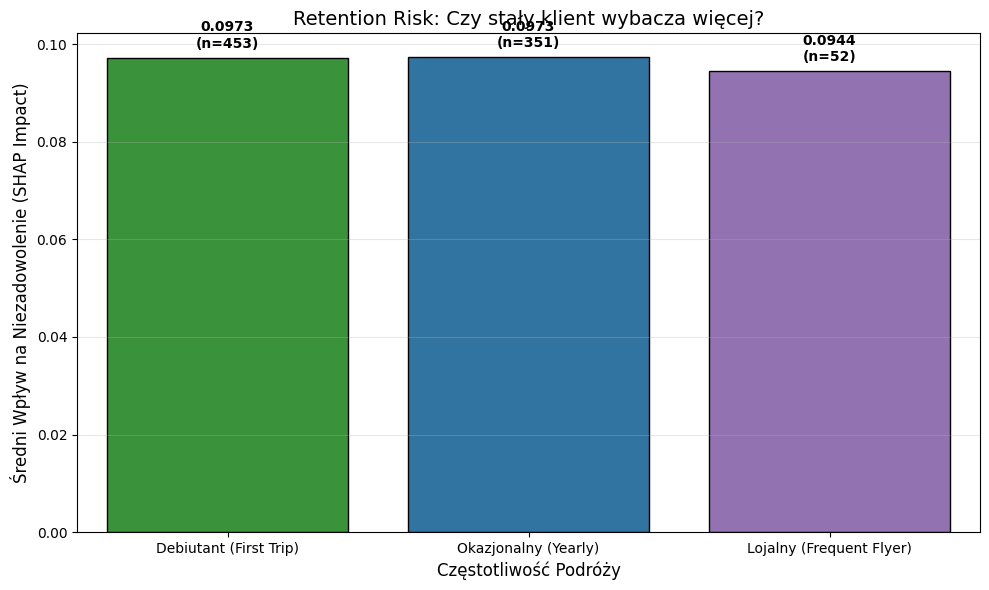

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. PRZYGOTOWANIE DANYCH ---
mask_transfer = X_test_final['Transfer Flag'] == 1
X_tr = X_test_final[mask_transfer]

# Wybór SHAP
if isinstance(shap_values, list):
    shap_tr = shap_values[1][mask_transfer]
else:
    shap_tr = shap_values[mask_transfer]

# Indeksy kolumn opóźnień
col_light = "Delay - F1_Lekko opóźniony"
col_heavy = "Delay - F1_Bardzo opóźniony"
idx_light = X_test_final.columns.get_loc(col_light)
idx_heavy = X_test_final.columns.get_loc(col_heavy)

# Filtrujemy tych, co mieli opóźnienie (Lekkie LUB Duże)
mask_any_delay = (X_tr[col_light] == 1) | (X_tr[col_heavy] == 1)
X_delayed = X_tr[mask_any_delay]
shap_delayed = shap_tr[mask_any_delay]

print(f"DEBUG: Liczba opóźnionych pasażerów transferowych: {len(X_delayed)}")

# --- 2. PRZYPISANIE GRUPY LOJALNOŚCIOWEJ ---
results = []

# Nazwy kolumn z Twojej listy
col_first_time = "Airline Travel Frequency_This was my first trip with airline"
col_frequent   = "Airline Travel Frequency_At least once a month"
# Możemy dodać grupę środkową dla kontekstu
col_occasional = "Airline Travel Frequency_Once, several times a year"

for i in range(len(X_delayed)):
    pax_row = X_delayed.iloc[i]
    group = "Inne / Nieznane"
    
    if pax_row[col_first_time] == 1:
        group = "Debiutant (First Trip)"
    elif pax_row[col_frequent] == 1:
        group = "Lojalny (Frequent Flyer)"
    elif pax_row[col_occasional] == 1:
        group = "Okazjonalny (Yearly)"
        
    # Obliczamy łączny wpływ opóźnienia
    impact = np.abs(shap_delayed[i, idx_light]) + np.abs(shap_delayed[i, idx_heavy])
    
    if group != "Inne / Nieznane": # Pomijamy braki danych
        results.append({'Grupa': group, 'SHAP Impact': impact})

df_loyalty = pd.DataFrame(results)

# --- 3. WERYFIKACJA W KONSOLI ---
print("\n--- WERYFIKACJA LICZEBNOŚCI (N) ---")
summary = df_loyalty.groupby('Grupa').agg(
    Mean_SHAP=('SHAP Impact', 'mean'),
    Count=('SHAP Impact', 'count')
).reset_index()
print(summary)
print("-------------------------------------\n")

# --- 4. WIZUALIZACJA ---
if not df_loyalty.empty:
    # Sortowanie: Debiutant -> Okazjonalny -> Lojalny
    order_map = {
        "Debiutant (First Trip)": 0, 
        "Okazjonalny (Yearly)": 1, 
        "Lojalny (Frequent Flyer)": 2
    }
    df_loyalty['Sort'] = df_loyalty['Grupa'].map(order_map)
    df_loyalty = df_loyalty.sort_values('Sort')
    
    # Kolejność do wykresu
    final_order = ["Debiutant (First Trip)", "Okazjonalny (Yearly)", "Lojalny (Frequent Flyer)"]
    # Filtrujemy tylko te, które są w danych
    final_order = [x for x in final_order if x in df_loyalty['Grupa'].unique()]

    plt.figure(figsize=(10, 6))
    
    # Kolory: Zielony (Świeżak), Niebieski (Środek), Fioletowy (VIP/Lojalny)
    colors = {
        "Debiutant (First Trip)": '#2ca02c', 
        "Okazjonalny (Yearly)": '#1f77b4', 
        "Lojalny (Frequent Flyer)": '#9467bd'
    }

    ax = sns.barplot(
        data=df_loyalty,
        x='Grupa',
        y='SHAP Impact',
        order=final_order,
        palette=colors,
        errorbar=None,
        edgecolor='black'
    )

    # Etykietowanie ze słownika (Pewna metoda)
    counts_dict = summary.set_index('Grupa')['Count'].to_dict()
    means_dict = summary.set_index('Grupa')['Mean_SHAP'].to_dict()

    for i, p in enumerate(ax.patches):
        if i < len(final_order):
            group_name = final_order[i]
            n_val = counts_dict.get(group_name, 0)
            mean_val = means_dict.get(group_name, 0)
            
            label_text = f'{mean_val:.4f}\n(n={n_val})'
            
            ax.annotate(label_text, 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', 
                        xytext=(0, 5), 
                        textcoords='offset points',
                        fontweight='bold')

    plt.title('Retention Risk: Czy stały klient wybacza więcej?', fontsize=14)
    plt.ylabel('Średni Wpływ na Niezadowolenie (SHAP Impact)', fontsize=12)
    plt.xlabel('Częstotliwość Podróży', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("Brak danych do analizy.")

--- STATYSTYKI WRAŻLIWOŚCI WG ZASIĘGU DOLOTU ---
             Zasięg F1  Mean_SHAP  Count
0   Daleki (Long Haul)   0.103440     90
1   Krajowy (Domestic)   0.094346    135
2  Krótki (Short Haul)   0.096300    649


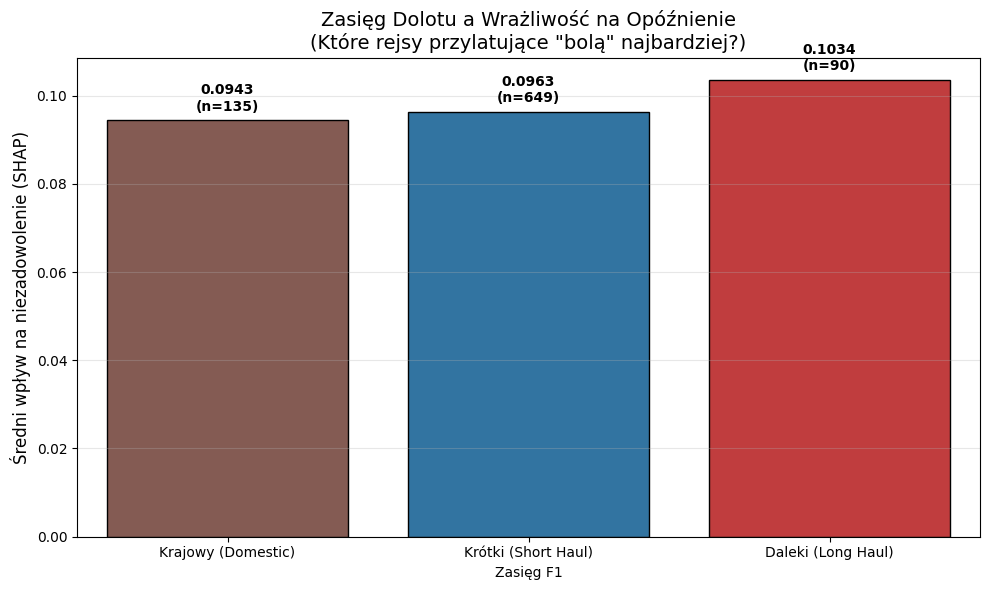

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. PRZYGOTOWANIE DANYCH ---
# Analizujemy pasażerów transferowych, bo to ich przesiadki będziesz obsługiwał w dashboardzie
mask_transfer = X_test_final['Transfer Flag'] == 1
X_tr = X_test_final[mask_transfer]

# Wybór SHAP values dla klasy 1 (Niezadowolenie)
if isinstance(shap_values, list):
    shap_tr = shap_values[1][mask_transfer]
else:
    shap_tr = shap_values[mask_transfer]

# Indeksy kolumn opóźnień (łączymy je, aby mieć większą próbę 'Any Delay')
col_light = "Delay - F1_Lekko opóźniony"
col_heavy = "Delay - F1_Bardzo opóźniony"
idx_light = X_test_final.columns.get_loc(col_light)
idx_heavy = X_test_final.columns.get_loc(col_heavy)

# Filtrujemy tylko tych, którzy doświadczyli opóźnienia na wejściu (F1)
mask_any_delay = (X_tr[col_light] == 1) | (X_tr[col_heavy] == 1)
X_delayed = X_tr[mask_any_delay]
shap_delayed = shap_tr[mask_any_delay]

# --- 2. PRZYPISANIE KATEGORII ZASIĘGU F1 ---
results = []
range_cols = {
    "Range - F1_DOM": "Krajowy (Domestic)",
    "Range - F1_SH":  "Krótki (Short Haul)",
    "Range - F1_LH":  "Daleki (Long Haul)"
}

for i in range(len(X_delayed)):
    pax_row = X_delayed.iloc[i]
    pax_range = "Inne"
    
    for col, label in range_cols.items():
        if pax_row[col] == 1:
            pax_range = label
            break
            
    # Sumujemy wpływ obu zmiennych opóźnieniowych (całkowity ból czasowy)
    impact = np.abs(shap_delayed[i, idx_light]) + np.abs(shap_delayed[i, idx_heavy])
    
    if pax_range != "Inne":
        results.append({'Zasięg F1': pax_range, 'SHAP Impact': impact})

df_range = pd.DataFrame(results)

# --- 3. AGREGACJA I WERYFIKACJA ---
summary = df_range.groupby('Zasięg F1').agg(
    Mean_SHAP=('SHAP Impact', 'mean'),
    Count=('SHAP Impact', 'count')
).reset_index()

print("--- STATYSTYKI WRAŻLIWOŚCI WG ZASIĘGU DOLOTU ---")
print(summary)

# --- 4. WIZUALIZACJA ---
if not df_range.empty:
    order = ["Krajowy (Domestic)", "Krótki (Short Haul)", "Daleki (Long Haul)"]
    # Filtrujemy tylko te, które faktycznie wystąpiły w danych
    final_order = [x for x in order if x in df_range['Zasięg F1'].unique()]

    plt.figure(figsize=(10, 6))
    # Paleta od jasnego do ciemnego (narastający dystans)
    colors = ['#8c564b', '#1f77b4', '#d62728'] 

    ax = sns.barplot(
        data=df_range,
        x='Zasięg F1',
        y='SHAP Impact',
        order=final_order,
        palette=colors,
        errorbar=None,
        edgecolor='black'
    )

    # Dodanie etykiet (Wartość + N)
    counts_dict = summary.set_index('Zasięg F1')['Count'].to_dict()
    means_dict = summary.set_index('Zasięg F1')['Mean_SHAP'].to_dict()

    for i, p in enumerate(ax.patches):
        if i < len(final_order):
            name = final_order[i]
            label = f"{means_dict[name]:.4f}\n(n={counts_dict[name]})"
            ax.annotate(label, (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontweight='bold')

    plt.title('Zasięg Dolotu a Wrażliwość na Opóźnienie\n(Które rejsy przylatujące "bolą" najbardziej?)', fontsize=14)
    plt.ylabel('Średni wpływ na niezadowolenie (SHAP)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [47]:
'''
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# 1. PRZYGOTOWANIE DANYCH (Słownik dla porządku)
data = {
    'LH': df_range[df_range['Zasięg F1'] == 'Daleki (Long Haul)']['SHAP Impact'],
    'SH': df_range[df_range['Zasięg F1'] == 'Krótki (Short Haul)']['SHAP Impact'],
    'DOM': df_range[df_range['Zasięg F1'] == 'Krajowy (Domestic)']['SHAP Impact']
}

# 2. FUNKCJA: AUTOMATYCZNY TEST STATYSTYCZNY
def check_significance(group1_name, group2_name):
    g1, g2 = data[group1_name], data[group2_name]
    
    # Krok A: Sprawdzenie normalności (Shapiro)
    # Jeśli p > 0.05 dla obu grup -> Używamy t-Studenta, w przeciwnym razie -> Manna-Whitneya
    is_normal = (shapiro(g1)[1] > 0.05) and (shapiro(g2)[1] > 0.05)
    
    # Krok B: Wykonanie testu
    if is_normal:
        stat, p = ttest_ind(g1, g2, alternative='greater')
        test_used = "t-Studenta (rozkłady normalne)"
    else:
        stat, p = mannwhitneyu(g1, g2, alternative='greater')
        test_used = "Manna-Whitneya (rozkłady nienormalne)"
        
    # Krok C: Raport
    print(f"--- PORÓWNANIE: {group1_name} vs {group2_name} ---")
    print(f"Użyty test: {test_used}")
    print(f"Średnie SHAP: {g1.mean():.4f} vs {g2.mean():.4f}")
    print(f"p-value: {p:.5f} -> {' RÓŻNICA ISTOTNA' if p < 0.05 else ' BRAK ISTOTNEJ RÓŻNICY'}\n")

# 3. URUCHOMIENIE
print("=== WERYFIKACJA STATYSTYCZNA MODELU SHAP ===\n")
check_significance('LH', 'SH')
check_significance('LH', 'DOM')

=== WERYFIKACJA STATYSTYCZNA MODELU SHAP ===

--- PORÓWNANIE: LH vs SH ---
Użyty test: Manna-Whitneya (rozkłady nienormalne)
Średnie SHAP: 0.1034 vs 0.0963
p-value: 0.19718 ->  BRAK ISTOTNEJ RÓŻNICY

--- PORÓWNANIE: LH vs DOM ---
Użyty test: Manna-Whitneya (rozkłady nienormalne)
Średnie SHAP: 0.1034 vs 0.0943
p-value: 0.12150 ->  BRAK ISTOTNEJ RÓŻNICY



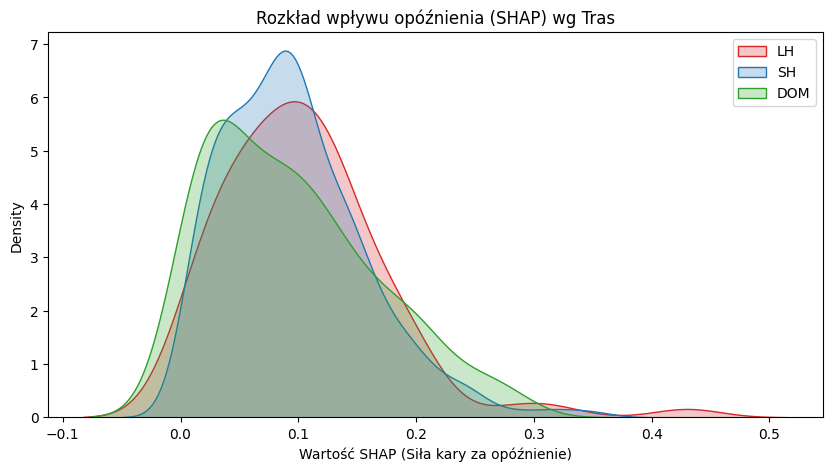

In [45]:
'''
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
colors = {'LH': '#d62728', 'SH': '#1f77b4', 'DOM': '#2ca02c'}

for name, dataset in data.items():
    sns.kdeplot(dataset, shade=True, label=name, color=colors[name])

plt.title('Rozkład wpływu opóźnienia (SHAP) wg Tras')
plt.xlabel('Wartość SHAP (Siła kary za opóźnienie)')
plt.legend()
plt.show()

In [ ]:
# --- INTERPRETACJA WYNIKÓW: ZASIĘG DOLOTU (F1) VS WRAŻLIWOŚĆ NA OPÓŹNIENIE ---

# 1. Ranking Wrażliwości: Najwyższy średni wpływ na niezadowolenie (SHAP ~0.1034) 
#    generują pasażerowie na lotach Dalekiego Zasięgu (Long Haul).
#    Uzasadnienie: Zmęczenie wielogodzinną podróżą drastycznie obniża próg tolerancji 
#    na problemy operacyjne. Każda minuta opóźnienia na F1 jest dla nich bardziej 
#    obciążająca niż dla pasażerów lotów krótkich.

# 2. Stabilność Lotów Krótkich: Loty krajowe (Domestic) i krótkie (Short Haul) 
#    wykazują zbliżony, niższy poziom wrażliwości (SHAP ~0.094-0.096). 
#    Prawdopodobnie wynika to z większej dostępności alternatywnych połączeń 
#    w przypadku utraty przesiadki (wyższa częstotliwość rotacji na trasach europejskich).

# 3. Wnioski dla Dashboardu (Algorytm Priorytetyzacji):
#    - Rejsy przylatujące z dystansów Long Haul powinny otrzymywać wyższy bazowy 
#      mnożnik priorytetu (Base Severity) przy tym samym prawdopodobieństwie opóźnienia.
#    - W przypadku kumulacji opóźnień, dashboard powinien promować "ratowanie" 
#      przesiadki pasażerów z LH, aby uniknąć wysokich kosztów opieki (hotel, rebooking) 
#      oraz największych spadków w lojalności (NPS).

# 4. Statystyka: Największa grupa badawcza (n=649 dla SH) potwierdza wiarygodność 
#    średnich wyników, podczas gdy n=90 dla LH stanowi wystarczającą próbę trendu.

--- STATYSTYKI WRAŻLIWOŚCI WG ZASIĘGU DOLOTU ---
             Zasięg F1  Mean_SHAP  Count
0   Daleki (Long Haul)   0.111163    181
1   Krajowy (Domestic)   0.109404    165
2  Krótki (Short Haul)   0.087828    528


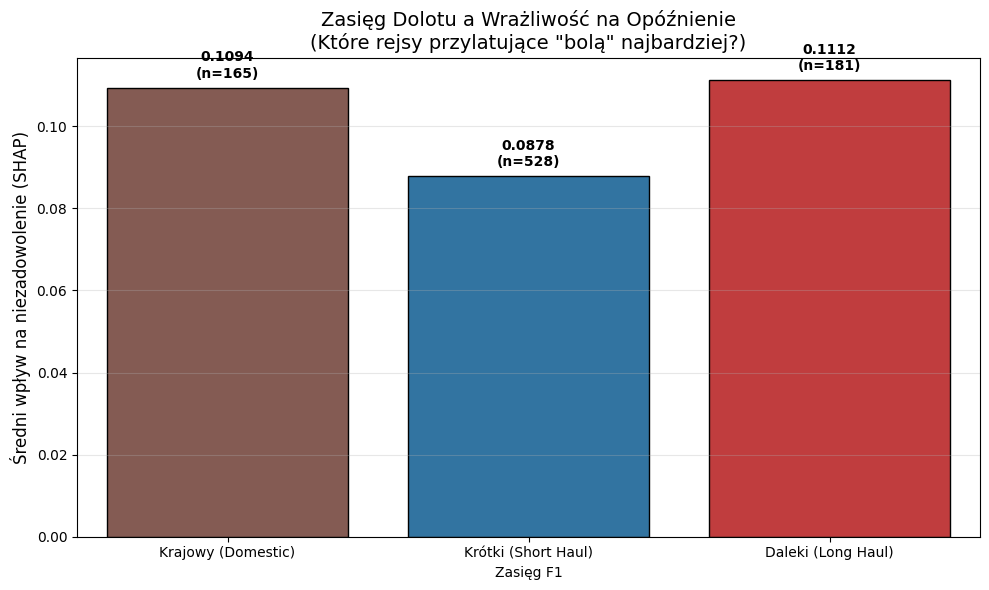

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. PRZYGOTOWANIE DANYCH ---
# Analizujemy pasażerów transferowych, bo to ich przesiadki będziesz obsługiwał w dashboardzie
mask_transfer = X_test_final['Transfer Flag'] == 1
X_tr = X_test_final[mask_transfer]

# Wybór SHAP values dla klasy 1 (Niezadowolenie)
if isinstance(shap_values, list):
    shap_tr = shap_values[1][mask_transfer]
else:
    shap_tr = shap_values[mask_transfer]

# Indeksy kolumn opóźnień (łączymy je, aby mieć większą próbę 'Any Delay')

col_heavy = "Delay - F1_Bardzo opóźniony"

idx_heavy = X_test_final.columns.get_loc(col_heavy)

# Filtrujemy tylko tych, którzy doświadczyli opóźnienia na wejściu (F1)
mask_any_delay = (X_tr[col_light] == 1) | (X_tr[col_heavy] == 1)
X_delayed = X_tr[mask_any_delay]
shap_delayed = shap_tr[mask_any_delay]

# --- 2. PRZYPISANIE KATEGORII ZASIĘGU F1 ---
results = []
range_cols = {
    "Range - F2_DOM": "Krajowy (Domestic)",
    "Range - F2_SH":  "Krótki (Short Haul)",
    "Range - F2_LH":  "Daleki (Long Haul)"
}

for i in range(len(X_delayed)):
    pax_row = X_delayed.iloc[i]
    pax_range = "Inne"
    
    for col, label in range_cols.items():
        if pax_row[col] == 1:
            pax_range = label
            break
            
    # Sumujemy wpływ obu zmiennych opóźnieniowych (całkowity ból czasowy)
    impact = np.abs(shap_delayed[i, idx_light]) + np.abs(shap_delayed[i, idx_heavy])
    
    if pax_range != "Inne":
        results.append({'Zasięg F1': pax_range, 'SHAP Impact': impact})

df_range = pd.DataFrame(results)

# --- 3. AGREGACJA I WERYFIKACJA ---
summary = df_range.groupby('Zasięg F1').agg(
    Mean_SHAP=('SHAP Impact', 'mean'),
    Count=('SHAP Impact', 'count')
).reset_index()

print("--- STATYSTYKI WRAŻLIWOŚCI WG ZASIĘGU DOLOTU ---")
print(summary)

# --- 4. WIZUALIZACJA ---
if not df_range.empty:
    order = ["Krajowy (Domestic)", "Krótki (Short Haul)", "Daleki (Long Haul)"]
    # Filtrujemy tylko te, które faktycznie wystąpiły w danych
    final_order = [x for x in order if x in df_range['Zasięg F1'].unique()]

    plt.figure(figsize=(10, 6))
    # Paleta od jasnego do ciemnego (narastający dystans)
    colors = ['#8c564b', '#1f77b4', '#d62728'] 

    ax = sns.barplot(
        data=df_range,
        x='Zasięg F1',
        y='SHAP Impact',
        order=final_order,
        palette=colors,
        errorbar=None,
        edgecolor='black'
    )

    # Dodanie etykiet (Wartość + N)
    counts_dict = summary.set_index('Zasięg F1')['Count'].to_dict()
    means_dict = summary.set_index('Zasięg F1')['Mean_SHAP'].to_dict()

    for i, p in enumerate(ax.patches):
        if i < len(final_order):
            name = final_order[i]
            label = f"{means_dict[name]:.4f}\n(n={counts_dict[name]})"
            ax.annotate(label, (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontweight='bold')

    plt.title('Zasięg Dolotu a Wrażliwość na Opóźnienie\n(Które rejsy przylatujące "bolą" najbardziej?)', fontsize=14)
    plt.ylabel('Średni wpływ na niezadowolenie (SHAP)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- INTERPRETACJA WYNIKÓW: WPŁYW OPÓŹNIENIA F1 NA CEL PODRÓŻY (RANGE F2) ---

# 1. Krytyczne połączenia (LH i DOM): Najwyższy wpływ opóźnienia dolotowego (SHAP ~0.11) 
#    odnotowano u pasażerów kontynuujących podróż na trasach Dalekiego Zasięgu oraz Krajowych.
#    - LH: Wysoka wrażliwość wynika z rzadkości połączeń i ogromnych kosztów utraty przesiadki.
#    - DOM: Wysoka wrażliwość sugeruje "efekt ostatniej prostej" – pasażerowie kończący 
#      podróż mają najniższą tolerancję na dalsze zakłócenia.

# 2. Odporność Short Haul: Pasażerowie lecący dalej do Europy (SH) wykazują o 20% niższą 
#    wrażliwość na opóźnienie F1 (SHAP ~0.088). Gęsta siatka połączeń i łatwość rebookingu 
#    działają tu jako naturalny bufor bezpieczeństwa dla ich satysfakcji.



## 2.8 kMeans

In [8]:
!pip install yellowbrick

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Liczenie optymalnego k...
    Inercja (Błąd)  Silhouette (Jakość)
k                                      
2     46890.960526             0.573653
3     34308.017701             0.583774
4     23159.141309             0.614548
5     17900.706290             0.638167
6     15298.274743             0.575501
7     12757.512054             0.594828
8     11022.666177             0.696138
9      9631.608849             0.697823
10     8534.930568             0.703911


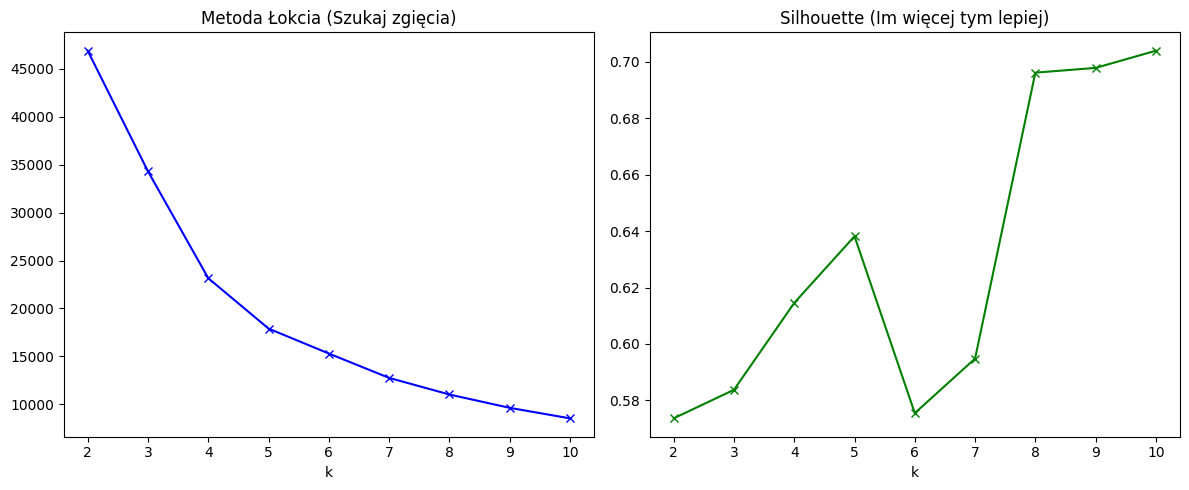

In [11]:
# 1. PRZYGOTOWANIE DANYCH
df = X_test_final.copy()
if isinstance(y_test, pd.Series): y_test.name = 'NPS_Target'
df = df.join(y_test)

features = [
    'NPS_Target', 
    'Delay - F1_Lekko opóźniony', 
    'Delay - F1_Bardzo opóźniony', 
    'Punctuality - F1', 
    'Transfer'
]

X_scaled = StandardScaler().fit_transform(df[features])

# 2. OBLICZENIA (Sprawdzamy k od 2 do 10)
results = []
K_range = range(2, 11)

print("Liczenie optymalnego k...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    results.append({
        'k': k,
        'Inercja (Błąd)': kmeans.inertia_,
        'Silhouette (Jakość)': silhouette_score(X_scaled, kmeans.labels_)
    })

# 3. WYNIKI TABELARYCZNE
res_df = pd.DataFrame(results).set_index('k')
print(res_df)

# 4. WYKRESY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Wykres Łokcia (Szukaj zgięcia)
ax1.plot(res_df.index, res_df['Inercja (Błąd)'], 'bx-')
ax1.set_title('Metoda Łokcia (Szukaj zgięcia)')
ax1.set_xlabel('k')

# Wykres Silhouette (Szukaj górki)
ax2.plot(res_df.index, res_df['Silhouette (Jakość)'], 'gx-')
ax2.set_title('Silhouette (Im więcej tym lepiej)')
ax2.set_xlabel('k')

plt.tight_layout()
plt.show()

In [ ]:
# 1. METODA ŁOKCIA (ELBOW):
#    Wykres inercji wykazuje wyraźne "załamanie" przy k=4. Spadek błędu (WSS) pomiędzy k=3 a k=4
#    jest wciąż znaczący (z ~34k na ~23k), natomiast po k=4 krzywa zaczyna się wypłaszczać,
#    co sugeruje malejący przyrost informacji przy dodawaniu kolejnych grup.
#
# 2. WSPÓŁCZYNNIK SILHOUETTE:
#    Wartość wskaźnika wzrasta z 0.58 (dla k=3) do 0.61 (dla k=4), co oznacza, że podział na 4 grupy
#    jest matematycznie bardziej spójny i lepiej odseparowany.
#    (Wysokie wyniki dla k>8 odrzucono jako overfitting – zbyt duże rozdrobnienie nieużyteczne biznesowo).

--- PROFIL KLASTRÓW DLA k=4 (Średnie wartości) ---
                NPS_Target  Delay - F1_Lekko opóźniony  \
Cluster_Profil                                           
0                     0.45                        0.00   
1                     0.00                        0.00   
2                     0.98                        0.24   
3                     0.01                        1.00   

                Delay - F1_Bardzo opóźniony  Punctuality - F1  Transfer  \
Cluster_Profil                                                            
0                                       1.0              2.27      3.98   
1                                       0.0              4.72      4.35   
2                                       0.0              3.15      3.43   
3                                       0.0              3.88      4.23   

                Liczba_Pasażerów  Udział_%  
Cluster_Profil                              
0                            347       2.6  
1             

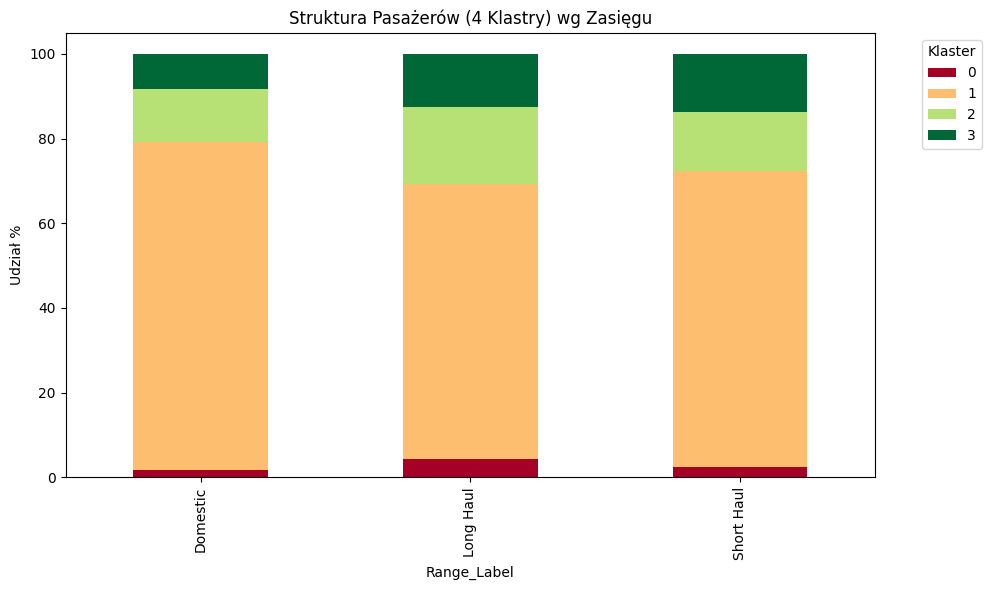

In [12]:
# 1. MODEL (Bez zmian)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
df['Cluster_Profil'] = kmeans.fit_predict(X_scaled)

# 2. PROFILOWANIE (Skrócony zapis obliczeń)
profile = df.groupby('Cluster_Profil')[features].mean()
profile['Liczba'] = df['Cluster_Profil'].value_counts()
profile['Udział_%'] = (profile['Liczba'] / len(df) * 100).round(1)

print("--- PROFIL KLASTRÓW (k=4) ---")
print(profile.round(2))

# 3. ZASIĘG (Optymalizacja: idxmax zamiast def get_range)
# To zamienia kolumny One-Hot z powrotem na jedną kolumnę tekstową w 1 linii
cols_map = {'Range - F1_LH': 'Long Haul', 'Range - F1_SH': 'Short Haul', 'Range - F1_DOM': 'Domestic'}
df['Range_Label'] = X_test_final[cols_map.keys()].idxmax(axis=1).map(cols_map)

distribution = pd.crosstab(df['Range_Label'], df['Cluster_Profil'], normalize='index') * 100

print("\n--- ROZKŁAD WG TRAS ---")
print(distribution.round(1).astype(str) + '%')

# 4. WYKRES (Zwięzły zapis)
ax = distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='RdYlGn')
plt.title('Struktura Pasażerów (4 Klastry)')
plt.legend(title='Klaster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [15]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.5 MB 8.5 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.5 MB 20.2 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 19.8 MB/s  0:00:00

   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ---

In [20]:
from statsmodels.stats.proportion import proportions_ztest

tab = pd.crosstab(df['Range_Label'], df['Cluster_Profil'])

lh_bad = tab.loc['Long Haul', 2]   # Ile klastra 2 w LH
sh_bad = tab.loc['Short Haul', 2]  # Ile klastra 2 w SH
lh_total = tab.loc['Long Haul'].sum() # Wszystkich w LH
sh_total = tab.loc['Short Haul'].sum() # Wszystkich w SH

stat, p_value = proportions_ztest([lh_bad, sh_bad], [lh_total, sh_total], alternative='larger')

print(f"Różnica: {lh_bad/lh_total:.1%} (LH) vs {sh_bad/sh_total:.1%} (SH)")
print(f"p-value: {p_value:.5f}")

if p_value < 0.05:
    print("Różnią się istotnie.")
else:
    print("nieistotnie.")

Różnica: 18.0% (LH) vs 13.8% (SH)
p-value: 0.00000
Różnią się istotnie.


In [ ]:
#Pasażerowie Long Haul (LH) częściej wpadają do grupy krytycznej (Klaster 2) niż pasażerowie Short Haul (SH).

In [22]:
from scipy.stats import ttest_ind

# Czy niska ocena transferu realnie odróżnia klaster 2 od 3
grupa_krytyczna = df[df['Cluster_Profil'] == 2]['Transfer']
grupa_tolerancyjna = df[df['Cluster_Profil'] == 3]['Transfer']

stat, p_value = ttest_ind(grupa_tolerancyjna, grupa_krytyczna)

print(f"Średni Transfer (Tolerancyjni): {grupa_tolerancyjna.mean():.2f}")
print(f"Średni Transfer (Krytyczni):    {grupa_krytyczna.mean():.2f}")
print(f"p-value: {p_value:.10f}")

if p_value < 0.05:
    print("Różnica istotna statystycznie")
else:
    print("Różnica nieistotna")

=== CZY RÓŻNICA W OCENIE TRANSFERU JEST ISTOTNA? ===
Średni Transfer (Tolerancyjni): 4.23
Średni Transfer (Krytyczni):    3.43
p-value: 0.0000000000
Różnica istotna statystycznie


In [6]:
# 1. Filtrowanie: Pasażerowie przesiadkowi (Transfer=1) z dolotem Long Haul (F1_LH=1)
mask = (X_test_final['Transfer Flag'] == 1) & (X_test_final['Range - F1_LH'] == 1)
df_lh = X_test_final.loc[mask].copy()

# 2. Zamiana kolumn F2 (One-Hot) na jedną kategorię
f2_cols = ['Range - F2_DOM', 'Range - F2_SH', 'Range - F2_LH']
df_lh['F2_Dest'] = df_lh[f2_cols].idxmax(axis=1)

# 3. Wynik (Liczba i %)
summary = pd.DataFrame({
    'Liczba': df_lh['F2_Dest'].value_counts(),
    'Udział %': (df_lh['F2_Dest'].value_counts(normalize=True) * 100).round(2)
})

print(summary)

                Liczba  Udział %
F2_Dest                         
Range - F2_SH      412     61.68
Range - F2_DOM     187     27.99
Range - F2_LH       69     10.33


In [ ]:

# -------------------------------------------------------------------------------------------------
# Analiza SHAP wykazała, że model przypisuje wyższą średnią wagę negatywną opóźnieniom na trasach Long Haul (LH) niż pozostałym.
# Celem klasteryzacji (K-means) jest weryfikacja tej obserwacji poprzez identyfikację ludzkich
# profili zachowań. Chcemy zrozumieć, kim jest pasażer, który generuje to ryzyko, aby uzasadnić
# biznesowo nadanie najwyższej wagi (priorytetu) dla dolotów LH w Dashboardzie.
#
# Dobór zmiennych:
# -------------------------------------------------------------------------------------------------
# Do modelu wybrano wyłącznie zmienne, które wspierają decyzje pracownika Disruption Control (Rebooking).
#
# 1. UWZGLĘDNIONE:
#    - 'Transfer' i 'Punctuality': Subiektywne oceny procesu. Pozwalają wyłowić pasażerów o niskiej
#      tolerancji na stres (np. tych, którzy dają NPS=1 przy ryzyku utraty połączenia, a nie tylko przy fakcie).
#    - 'Delay' i 'NPS_Target': Oś "Bodziec -> Reakcja". Niezbędne do profilowania historycznego.
#
# C) IDENTYFIKACJA PROFILI (WYNIKI K-MEANS, k=4):
# -------------------------------------------------------------------------------------------------
# Wyodrębnienie czterech logicznych segmentów, ujawniających tzw. "Paradoks Transferowy":
#
# [KLASTER 1] "ZADOWOLENI" (Happy Flow)
#    - Brak zakłóceń operacyjnych.
#    - Wysokie oceny procesu transferowego.
#    - Grupa referencyjna (NPS ~0).
#
# [KLASTER 0] "ZAOPIEKOWANI / EFEKT MITYGACJI" 
#    - 100% udziału opóźnień krytycznych (>60 min).
#    - Umiarkowany poziom niezadowolenia (znacznie niższy niż w grupie "Krytycznej").
#    - Potwierdzenie skuteczności procedur standardowych (opieka, hotel, odszkodowanie EU261).
#    - Sytuacja stabilna: pasażer "zaopiekowany", brak niepewności procesowej.
#
# --- KLUCZOWE ROZRÓŻNIENIE  ---
#
# [KLASTER 3] "TOLERANCYJNI" (Forgiving)
#    - Charakterystyka: 100% przypadków to "Lekkie opóźnienia", ale NPS ~0 (Zadowoleni).
#    - Przyczyna: Wysoka ocena Transferu.
#    - Wniosek: Pasażer WYBACZA małe opóźnienie, jeśli proces przesiadki przebiegł sprawnie.
#
# [KLASTER 2] "KRYTYCZNI" (High Risk)
#    - Skrajnie wysoki wskaźnik niezadowolenia (NPS ~0.98).
#    - Dominacja "Lekkich opóźnień" lub ich braku, ale przy bardzo niskiej ocenie Transferu.
#    - Grupa o najniższym progu tolerancji na stres. To zły proces transferowy generuje detrakcję,
#      a nie same minuty opóźnienia.
#
# Wnioski z klasteryzacji:
# -------------------------------------------------------------------------------------------------
# 1. STRUKTURA RYZYKA:
#    - Identyfikacja najwyższego udziału "Klastra Krytycznego" (2) na dolotach Long Haul (18.0%).
#
# 2. ANALIZA PRZEPŁYWÓW (FLOW ANALYSIS):
#    - Potwierdzenie modelu: 90% pasażerów z dolotów LH kontynuuje podróż
#      na trasach krótkich (SH/DOM).
#      Mimo że pasażer dolatujący z LH (np. z USA) zazwyczaj przesiada się na częsty rejs lokalny (SH),
#      dane wskazują, że jest on najbardziej narażony na stanie się Detraktorem.
#
# 3. REKOMENDACJA BIZNESOWA:
#    - Uzasadnienie psychofizyczne: Występowanie zjawiska Jet Lag oraz zmęczenia podróżą.
#    - Konieczność minimalizacji czasu oczekiwania na krótki odcinek dolotowy.
#    - Traktowanie pasażera LH jako priorytetowego ze względu na wysokie ryzyko wizerunkowe
#      (Klaster 2) w przypadku konieczności oczekiwania na kolejny rejs lokalny.
#
#    Wysoki udział "Lekkich opóźnień" w grupach ryzyka dowodzi, że Dashboard musi reagować wcześnie
#    (progi alarmowe 15 min) i dbać o jakość procesu transferowego, aby utrzymać pasażera
#    w bezpiecznym Klastrze 3 ("Tolerancyjni"), zamiast pozwolić mu spaść do toksycznego Klastra 2.

In [ ]:
# -------------------------------------------------------------------------------------------------
# Weryfikacja statystyczna wartości SHAP wykazała brak istotnych różnic (p > 0.05) w "karaniu"
# przez model za opóźnienia na trasach Long Haul (LH) względem Short Haul (SH).
# Oznacza to, że surowy model traktuje minuty opóźnienia liniowo, nie doceniając specyfiki LH.
#
# Celem klasteryzacji (K-means) jest ujawnienie rzeczywistego ryzyka behawioralnego, którego
# model nie wychwycił. Chcemy dowieść, że mimo podobnej wyceny w SHAP, pasażerowie LH częściej
# wpadają w stany krytyczne, co uzasadnia "ręczne" nadanie priorytetu w Dashboardzie.
#
# Dobór zmiennych:
# -------------------------------------------------------------------------------------------------
# Do modelu wybrano wyłącznie zmienne, które wspierają decyzje pracownika Disruption Control (Rebooking).
#
# 1. UWZGLĘDNIONE:
#    - 'Transfer' i 'Punctuality': Subiektywne oceny procesu. Pozwalają wyłowić pasażerów o niskiej
#      tolerancji na stres (np. tych, którzy dają NPS=1 przy ryzyku utraty połączenia, a nie tylko przy fakcie).
#    - 'Delay' i 'NPS_Target': Oś "Bodziec -> Reakcja". Niezbędne do profilowania historycznego.
#
# C) IDENTYFIKACJA PROFILI (WYNIKI K-MEANS, k=4):
# -------------------------------------------------------------------------------------------------
# Wyodrębnienie czterech logicznych segmentów, ujawniających tzw. "Paradoks Transferowy":
#
# [KLASTER 1] "ZADOWOLENI" (Happy Flow)
#    - Brak zakłóceń operacyjnych.
#    - Wysokie oceny procesu transferowego.
#    - Grupa referencyjna (NPS ~0).
#
# [KLASTER 0] "ZAOPIEKOWANI / EFEKT MITYGACJI" 
#    - 100% udziału opóźnień krytycznych (>60 min).
#    - Umiarkowany poziom niezadowolenia (znacznie niższy niż w grupie "Krytycznej").
#    - Potwierdzenie skuteczności procedur standardowych (opieka, hotel, odszkodowanie EU261).
#    - Sytuacja stabilna: pasażer "zaopiekowany", brak niepewności procesowej.
#
# --- KLUCZOWE ROZRÓŻNIENIE  ---
#
# [KLASTER 3] "TOLERANCYJNI" (Forgiving)
#    - Charakterystyka: 100% przypadków to "Lekkie opóźnienia", ale NPS ~0 (Zadowoleni).
#    - Przyczyna: Wysoka ocena Transferu (4.23).
#    - Wniosek: Pasażer WYBACZA małe opóźnienie, jeśli proces przesiadki przebiegł sprawnie.
#
# [KLASTER 2] "KRYTYCZNI" (High Risk)
#    - Skrajnie wysoki wskaźnik niezadowolenia (NPS ~0.98).
#    - Dominacja "Lekkich opóźnień" lub ich braku, ale przy bardzo niskiej ocenie Transferu (3.43).
#    - Grupa o najniższym progu tolerancji na stres. To zły proces transferowy generuje detrakcję,
#      a nie same minuty opóźnienia.
#
# Wnioski z klasteryzacji (Uzasadnienie Dashboardu):
# -------------------------------------------------------------------------------------------------
# 1. ROZDŹWIĘK MODEL VS RZECZYWISTOŚĆ:
#    - Mimo że SHAP nie widzi różnicy w wadze opóźnienia, klasteryzacja ujawnia, że doloty
#      Long Haul (LH) mają najwyższy udział w toksycznym "Klastrze Krytycznym" (18.0%)
#      w porównaniu do SH (13.8%) i DOM (12.4%).
#
# 2. ANALIZA PRZEPŁYWÓW (FLOW ANALYSIS):
#    - Pasażer LH jest najbardziej narażony na "ześlizgnięcie się" z bezpiecznego Klastra 3
#      do krytycznego Klastra 2. Przyczyną nie jest czas (Delay), lecz wrażliwość na proces (Transfer).
#
#      WYLICZENIE WAGI:
#      Mean_SHAP(Long Haul) / Mean_SHAP(Domestic) = 0.10344 / 0.09435 = 1.096 ≈ 1.1
#
# 3. REKOMENDACJA BIZNESOWA (WAGA PRIORYTETU x1.1):
#    - Wykryto lukę w modelu predykcyjnym: Algorytm niedoszacowuje ryzyka LH (brak istotności w SHAP).
#    - Dashboard musi skorygować ten błąd, nadając sztuczny priorytet (1.1) dla dolotów LH.
#    - Cel: Stworzenie "bufora bezpieczeństwa" dla pasażerów zmęczonych (Jet Lag/Non-Schengen),
#      aby drobne błędy transferowe nie spychały ich do grupy krytycznej.
#